## Variations in Hospital Charge and Determinants in USA
### Monopolistic Competition in Healthcare Sector

Generally speaking, USA healthcare sector behaves as monopolistic competition that allows the providers to set their own prices for same or similar services. The monopolistic power to the providers comes from either real or perceived differences in quality of medical and related services. In health sector new technologies can also be used to signal quality even when their clinical usefulness is not proven.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
from pandas import ExcelWriter
from pandas import ExcelFile
import geopandas as gpd
import json
import folium
from collections import Counter
import seaborn as sns

font = {'weight' : 'bold',
        'size'   : 14}

plt.rc('font', **font)
rcParams['figure.figsize'] = 10, 8

%matplotlib inline

## About the Data

####  - 49 States and DC, excluding Maryland
####  - 35 Procedures(Ambulatory Payment Classifications)
####  -The data represents 15.9% (428 million) of Outpatient Prospective Payment System(OPPS) hospital services and  23.3% ($14.3        billion) of the total  Medicare allowed amount charges.
####  - Only One year Data is used because of differences in data structure for previous years.
####  - All inferences and conclusions are based on and for 2016 Only.

In [2]:
# This is hospital information data, is not charge data.
# This data is obtained from CMS website, the data is updated latest in 2016
Hospital_Information=pd.read_csv('data/Hospital_General_Information.csv')
Hospital_Information.head()

,Provider ID,Hospital Name,Address,City,State,ZIP Code,County Name,Phone Number,Hospital Type,Hospital Ownership,...,Readmission national comparison footnote,Patient experience national comparison,Patient experience national comparison footnote,Effectiveness of care national comparison,Effectiveness of care national comparison footnote,Timeliness of care national comparison,Timeliness of care national comparison footnote,Efficient use of medical imaging national comparison,Efficient use of medical imaging national comparison footnote,Location
0,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,MARSHALL,2565938310,Acute Care Hospitals,Government - Hospital District or Authority,...,NaN,Same as the national average,NaN,Above the national average,NaN,Above the national average,NaN,Below the national average,NaN,"2505 U S HIGHWAY 431 NORTH BOAZ, AL 35957"
1,10012,DEKALB REGIONAL MEDICAL CENTER,200 MED CENTER DRIVE,FORT PAYNE,AL,35968,DE KALB,2568453150,Acute Care Hospitals,Proprietary,...,NaN,Below the national average,NaN,Same as the national average,NaN,Above the national average,NaN,Same as the national average,NaN,"200 MED CENTER DRIVE FORT PAYNE, AL 35968"
2,10131,CRESTWOOD MEDICAL CENTER,ONE HOSPITAL DR SE,HUNTSVILLE,AL,35801,MADISON,2568823100,Acute Care Hospitals,Proprietary,...,NaN,Below the national average,NaN,Same as the national average,NaN,Below the national average,NaN,Same as the national average,NaN,"ONE HOSPITAL DR SE HUNTSVILLE, AL 35801"
3,11304,CHOCTAW GENERAL HOSPITAL,"401 VANITY FAIR LANE, PO BOX 618",BUTLER,AL,36904,CHOCTAW,2054599100,Critical Access Hospitals,Voluntary non-profit - Private,...,Results are not available for this reporting p...,Not Available,There are too few measures or measure groups r...,Same as the national average,NaN,Same as the national average,NaN,Not Available,Results are not available for this reporting p...,"401 VANITY FAIR LANE, PO BOX 618 BUTLER, AL 36904"
4,21301,PROVIDENCE VALDEZ MEDICAL CENTER,PO BOX 550,VALDEZ,AK,99686,NaN,9078352249,Critical Access Hospitals,Government - Local,...,There are too few measures or measure groups r...,Not Available,There are too few measures or measure groups r...,Not Available,Results are not available for this reporting p...,Not Available,Results are not available for this reporting p...,Not Available,There are too few measures or measure groups r...,"PO BOX 550 VALDEZ, AK 99686"


In [3]:
Counter(Hospital_Information['Patient experience national comparison'])

Counter({'Above the national average': 1178,
         'Below the national average': 1098,
         'Not Available': 1340,
         'Same as the national average': 1156})

In [4]:
Hospital_Information.columns

Index(['Provider ID', 'Hospital Name', 'Address', 'City', 'State', 'ZIP Code',
       'County Name', 'Phone Number', 'Hospital Type', 'Hospital Ownership',
       'Emergency Services', 'Meets criteria for meaningful use of EHRs',
       'Hospital overall rating', 'Hospital overall rating footnote',
       'Mortality national comparison',
       'Mortality national comparison footnote',
       'Safety of care national comparison',
       'Safety of care national comparison footnote',
       'Readmission national comparison',
       'Readmission national comparison footnote',
       'Patient experience national comparison',
       'Patient experience national comparison footnote',
       'Effectiveness of care national comparison',
       'Effectiveness of care national comparison footnote',
       'Timeliness of care national comparison',
       'Timeliness of care national comparison footnote',
       'Efficient use of medical imaging national comparison',
       'Efficient use of medi

In [5]:
# Keep only columns we want to use
Hospital_Information=Hospital_Information[['Provider ID', 'Hospital Name', 'Address', 'City', 'State', 'ZIP Code',
       'County Name','Hospital Type', 'Hospital Ownership','Patient experience national comparison',
       'Emergency Services','Effectiveness of care national comparison','Efficient use of medical imaging national comparison','Readmission national comparison',
       'Hospital overall rating','Location']]

In [6]:
# Import 2016 Medicare Outpatient Hospital charge data 

OutPatmedicarecharge=pd.read_csv('data/Provider_Outpatient_Hospital_Charge_Data_by_APC__CY2016.csv')

#OutPatmedicarecharge=pd.read_csv('data/Provider_Outpatient_Hospital_Charge_Data_by_APC__CY2015.csv')
#OutPatmedicarecharge.head()
# to join charge data with hospital information data, we take upper cases of string columns 

OutPatmedicarecharge['Provider Name']=OutPatmedicarecharge['Provider Name'].apply(lambda x: x.upper())
OutPatmedicarecharge['Provider Street Address']=OutPatmedicarecharge['Provider Street Address'].apply(lambda x: x.upper())
OutPatmedicarecharge['Provider City']=OutPatmedicarecharge['Provider City'].apply(lambda x: x.upper())
OutPatmedicarecharge['Provider State']=OutPatmedicarecharge['Provider State'].apply(lambda x: x.upper())


### Average Estimated Submitted Charges
The provider's average estimated submitted charge for services covered by Medicare for the APC. The average charges submitted vary from hospital to hospital because of differences in hospital charge structures.
### Average Total Payments
The average of total payments to the provider for the APC including the Medicare Payments for APCs. Average Total Payments also include co-payment and deductible amounts that the patient is responsible for.
### Average Medicare Payment Amount
The amount Medicare Paid to the hospitals or providers.

### Total Observations: the data has total of 27652 APC services at different hospitals participating in OPPS.
### The overall Average charge submitted by hospitals is $41,633.24 (It is average of average charges)

In [7]:
# Check desctriptiptive statistics
OutPatmedicarecharge.drop(['Provider ID','Provider Zip Code','APC'],axis=1).describe().round(2)

,Comprehensive APC Services,Average Estimated Total Submitted Charges,Average Medicare Allowed Amount,Average Medicare Payment Amount,Outlier Comprehensive APC Services,Average Medicare Outlier Amount
count,27652.00,27652.00,27652.00,27652.00,17130.00,3387.00
mean,101.38,41633.24,7755.54,6756.04,7.50,1550.50
std,225.45,36341.61,6696.64,6508.88,30.15,1079.98
min,11.00,214.43,105.81,101.96,0.00,137.63
25%,19.00,18362.50,3557.55,2805.68,0.00,1016.61
50%,37.00,29937.88,5010.95,3959.43,0.00,1293.52
75%,85.00,52103.52,9000.21,7717.88,0.00,1727.71
max,4959.00,512630.39,43837.58,42549.58,1067.00,18819.48


In [8]:
# check state incuded in the data
OutPatmedicarecharge['Provider State'].unique()

array(['AL', 'AK', 'AZ', 'AR', 'CA', 'CT', 'CO', 'DE', 'DC', 'FL', 'ME',
       'GA', 'IL', 'IA', 'HI', 'ID', 'MA', 'IN', 'MI', 'KS', 'KY', 'LA',
       'MN', 'MO', 'MT', 'NH', 'MS', 'NY', 'NC', 'NE', 'NV', 'NJ', 'OH',
       'OK', 'OR', 'PA', 'NM', 'ND', 'TX', 'UT', 'RI', 'SC', 'SD', 'TN',
       'VT', 'VA', 'WA', 'WI', 'WV', 'WY'], dtype=object)

In [9]:
# create State Dictionary
us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY',
}

In [10]:
# convert from State dictionary to data frame 
state_df=pd.DataFrame.from_dict(us_state_abbrev, orient='index')\
         .reset_index()
# rename columns   
state_df.columns=['State','Provider State']
state_df.head()

,State,Provider State
0,Alabama,AL
1,Alaska,AK
2,Arizona,AZ
3,Arkansas,AR
4,California,CA


In [11]:
# import zipcodes by state and county data
#zipcodes=pd.read_csv('data/ZIP-COUNTY-FIPS_2017-06.csv')
#print(zipcodes.head())

# create a county column by replace County from COUNTYNAME column
#zipcodes['County']=zipcodes.COUNTYNAME.str.replace('(County)','',regex=True)
# keep only three columns listed
#zipcodes=zipcodes[['ZIP','County','STATE']]

# rename the columns
#zipcodes.columns=['Provider Zip Code','County','Provider State']
# merge zipcode data with state_df
#state_data=pd.merge(state_df,zipcodes, how= 'inner', on='Provider State' )
#state_data.head()

In [12]:
## merge State data with Outpatient charge data
#merged_df=pd.merge(state_data,OutPatmedicarecharge, how='inner', on=['Provider State','Provider Zip Code'])
#merged_df.head()

### Large gap between Medicare Allowed charges and what the Providers charge

(array([    0.,  5000., 10000., 15000., 20000., 25000., 30000., 35000.,
        40000., 45000.]), <a list of 10 Text xticklabel objects>)

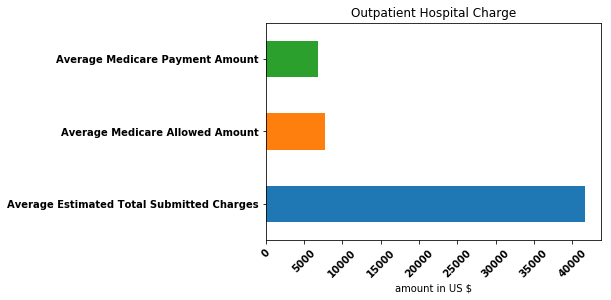

In [13]:
# plot hospital charges, medicare allowed amount, and medicare payments
OutPatmedicarecharge.iloc[:,10:13].describe().iloc[1,0:4].plot(kind='barh')
plt.title('Outpatient Hospital Charge')
plt.xlabel("amount in US $")
plt.xticks(rotation='45')

#### We can also see State Level Average  for the three types of charges

In [14]:
# join outpatient medicare hospital charge data with state_df
charge_data=pd.merge(state_df,OutPatmedicarecharge,how='inner',on='Provider State')
charge_data.shape

(27652, 16)

In [15]:
# create state list
state_list=state_df['State'].unique().tolist()

### This function creates interactive analysis

In [16]:
### This function creates interactive analysis
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [17]:
def f(x):
    OutPatmedicarecharge_df=charge_data
    OutPatmedicarecharge_df=OutPatmedicarecharge_df[OutPatmedicarecharge_df['State']==x]
    by_state_desc = OutPatmedicarecharge_df.iloc[:,11:14].describe()
    by_state_desc.iloc[1,0:4].plot(kind='bar')
    state_plot=plt.title('Outpatient Hospital Charges')
    plt.ylabel("amount in US $")
    return state_plot

In [18]:
interactive(f,x=state_list)

interactive(children=(Dropdown(description='x', options=('Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'District of Columbia', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming'), value='Alabama'), Output()), _dom_classes=('widget-interact',))

In [19]:
# rename hospital information data to match with charge data(hospital charge data)
Hospital_Information.columns=['Provider ID', 'Provider Name', 'Provider Street Address', 
                              'Provider City', 'Provider State', 'Provider Zip Code',
                              'County','Hospital Type', 'Hospital Ownership',
                              'Patient experience national comparison','Emergency Services',
                              'Effectiveness of care national comparison',
                              'Efficient use of medical imaging national comparison',
                              'Readmission national comparison', 'Hospital overall rating',
                              'Location']

In [20]:
# merge charge_data with hospital Informaation data
Merged_df2=pd.merge(charge_data,Hospital_Information, how='left',on =['Provider ID', 'Provider Street Address', 'Provider City', 'Provider State', 'Provider Zip Code'])
print('shape :', Merged_df2.shape)
Merged_df2.columns


shape : (27652, 27)


Index(['State', 'Provider State', 'Provider ID', 'Provider Name_x',
       'Provider Street Address', 'Provider City', 'Provider Zip Code',
       'Provider HRR', 'APC', 'APC Description', 'Comprehensive APC Services',
       'Average Estimated Total Submitted Charges',
       'Average Medicare Allowed Amount', 'Average Medicare Payment Amount',
       'Outlier Comprehensive APC Services', 'Average Medicare Outlier Amount',
       'Provider Name_y', 'County', 'Hospital Type', 'Hospital Ownership',
       'Patient experience national comparison', 'Emergency Services',
       'Effectiveness of care national comparison',
       'Efficient use of medical imaging national comparison',
       'Readmission national comparison', 'Hospital overall rating',
       'Location'],
      dtype='object')

In [21]:
# drop  duplicate columns
Merged_df2=Merged_df2.drop('Provider Name_y',axis=1)

In [22]:
# rename columns
Merged_df2=Merged_df2.rename(columns={'Provider Name_x':'Provider Name'})
Merged_df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27652 entries, 0 to 27651
Data columns (total 26 columns):
State                                                   27652 non-null object
Provider State                                          27652 non-null object
Provider ID                                             27652 non-null int64
Provider Name                                           27652 non-null object
Provider Street Address                                 27652 non-null object
Provider City                                           27652 non-null object
Provider Zip Code                                       27652 non-null int64
Provider HRR                                            27652 non-null object
APC                                                     27652 non-null int64
APC Description                                         27652 non-null object
Comprehensive APC Services                              27652 non-null int64
Average Estimated Total Submitted Cha

In [23]:
# extract lat and Long data from parethesis
Merged_df2['lat_Long']=Merged_df2.Location.str.extract('\(([^)]+)\)',expand=True)
# break lat_long column into lat and long columns
Merged_df2[['Lat','Long']]=Merged_df2.lat_Long.str.split(',',expand=True)
Merged_df2.head()

,State,Provider State,Provider ID,Provider Name,Provider Street Address,Provider City,Provider Zip Code,Provider HRR,APC,APC Description,...,Patient experience national comparison,Emergency Services,Effectiveness of care national comparison,Efficient use of medical imaging national comparison,Readmission national comparison,Hospital overall rating,Location,lat_Long,Lat,Long
0,Alabama,AL,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,36301,AL - Dothan,5123,Level 3 Musculoskeletal Procedures,...,Below the national average,True,Same as the national average,Same as the national average,Below the national average,2,"1108 ROSS CLARK CIRCLE DOTHAN, AL 36301 (31.21...","31.214058, -85.361725",31.214058,-85.361725
1,Alabama,AL,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,36301,AL - Dothan,5124,Level 4 Musculoskeletal Procedures,...,Below the national average,True,Same as the national average,Same as the national average,Below the national average,2,"1108 ROSS CLARK CIRCLE DOTHAN, AL 36301 (31.21...","31.214058, -85.361725",31.214058,-85.361725
2,Alabama,AL,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,36301,AL - Dothan,5125,Level 5 Musculoskeletal Procedures,...,Below the national average,True,Same as the national average,Same as the national average,Below the national average,2,"1108 ROSS CLARK CIRCLE DOTHAN, AL 36301 (31.21...","31.214058, -85.361725",31.214058,-85.361725
3,Alabama,AL,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,36301,AL - Dothan,5165,Level 5 ENT Procedures,...,Below the national average,True,Same as the national average,Same as the national average,Below the national average,2,"1108 ROSS CLARK CIRCLE DOTHAN, AL 36301 (31.21...","31.214058, -85.361725",31.214058,-85.361725
4,Alabama,AL,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,36301,AL - Dothan,5191,Level 1 Endovascular Procedures,...,Below the national average,True,Same as the national average,Same as the national average,Below the national average,2,"1108 ROSS CLARK CIRCLE DOTHAN, AL 36301 (31.21...","31.214058, -85.361725",31.214058,-85.361725


### Majority of the services are provided by  'Voluntary non-profit - Private': total of 13,188

In [24]:
# Count of hospital by ownership type
Counter(Merged_df2['Hospital Ownership'])

Counter({'Government - Federal': 60,
         'Government - Hospital District or Authority': 1785,
         'Government - Local': 843,
         'Government - State': 523,
         'Physician': 360,
         'Proprietary': 4512,
         'Tribal': 1,
         'Voluntary non-profit - Church': 2665,
         'Voluntary non-profit - Other': 2553,
         'Voluntary non-profit - Private': 13188,
         nan: 1162})

In [25]:
# count of services taken places by hospitals ownership type
Merged_df2[['Hospital Ownership','Provider Name']]\
.groupby('Hospital Ownership').count().sort_values('Provider Name',ascending=False)

,Provider Name
Hospital Ownership,
Voluntary non-profit - Private,13188
Proprietary,4512
Voluntary non-profit - Church,2665
Voluntary non-profit - Other,2553
Government - Hospital District or Authority,1785
Government - Local,843
Government - State,523
Physician,360
Government - Federal,60


### 1261 unique Voluntary non-profit - Private Hospitals 
### 599 Proprietary Hospitals
### Only 10 Federal Government Hospitals in the data

In [26]:
### Find count of unique hospitals by ownership type and plot
Merged_df2.groupby('Hospital Ownership')['Provider Name'].nunique().sort_values(ascending=False)

Hospital Ownership
Voluntary non-profit - Private                 1261
Proprietary                                     599
Voluntary non-profit - Other                    297
Government - Hospital District or Authority     240
Voluntary non-profit - Church                   230
Government - Local                              138
Physician                                        62
Government - State                               36
Government - Federal                             10
Tribal                                            1
Name: Provider Name, dtype: int64

Text(0.5,0,'Number of Hospitals')

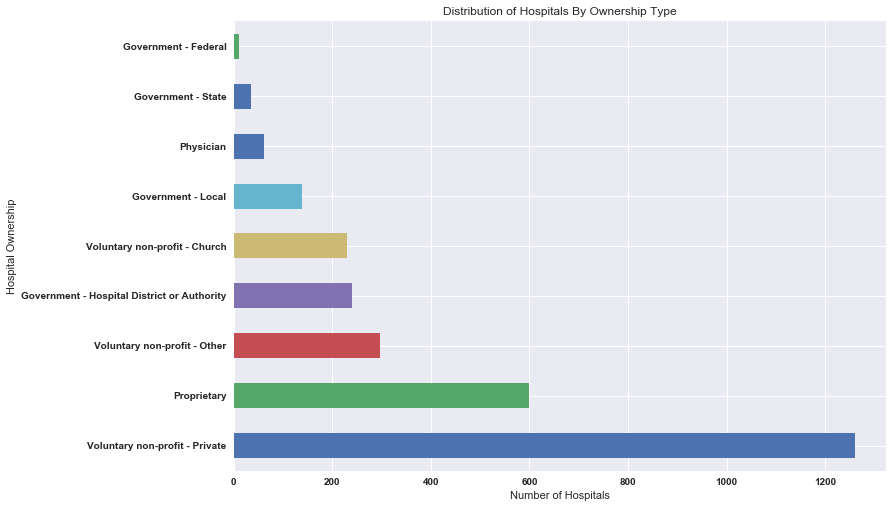

In [169]:
### Find count of unique hospitals by ownership type and plot
Merged_df2.groupby('Hospital Ownership')['Provider Name'].nunique()\
.sort_values(ascending=False).drop('Tribal',axis=0).plot(kind='barh')
plt.title('Distribution of Hospitals By Ownership Type')
plt.xlabel("Number of Hospitals")

In [28]:
# where is the Tribal Hospital?
Merged_df2[Merged_df2['Hospital Ownership']=='Tribal'][['State','Provider Name']]

,State,Provider Name
19585,Oklahoma,MUSCOGEE (CREEK) NATION MEDICAL CENTER


## Lists of  Ten unique Federal Government Hospitals 

In [29]:
# Check list of Goverment Hospitals
Counter(Merged_df2[Merged_df2['Hospital Ownership']=='Government - Federal']['Provider Name'])

Counter({'BETH ISRAEL DEACONESS HOSPITAL-MILTON INC': 5,
         'MEDICAL CENTER AT ELIZABETH PLACE': 1,
         'PLAINS REGIONAL MEDICAL CENTER': 6,
         'REDLANDS COMMUNITY HOSPITAL': 6,
         'REGIONAL MEDICAL CENTER OF SAN JOSE': 11,
         'RIDEOUT MEMORIAL HOSPITAL': 11,
         'ST CLAIRE REGIONAL MEDICAL CENTER': 7,
         'TEXAS HEALTH PRESBYTERIAN HOSPITAL ALLEN': 5,
         'TROY REGIONAL MEDICAL CENTER': 3,
         'WILCOX MEMORIAL HOSPITAL': 5})

### Hospital charge by ownership type shows proprietary hospitals charged the highest 
### Local Government hospitals charged lowest amount
### Tribal is the lowest but there is one Tribal provider in the data.

Text(0.5,1,'Median Hospital Charge by Ownership Type')

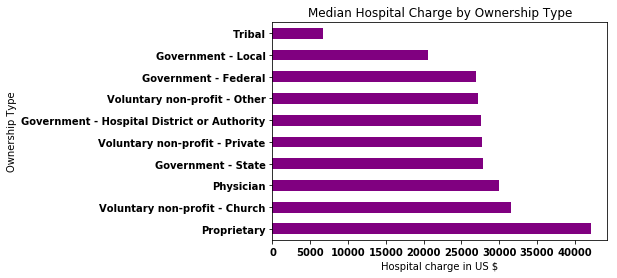

In [30]:
# plot hospital charges by Ownership Type

Merged_df2[['Hospital Ownership','Average Estimated Total Submitted Charges']]\
.groupby('Hospital Ownership').median().sort_values('Average Estimated Total Submitted Charges',ascending=False)\
.plot(kind='barh',color='purple',legend=False)

plt.xlabel("Hospital charge in US $")
plt.ylabel("Ownership Type")
plt.title("Median Hospital Charge by Ownership Type")

In [31]:
Counter(Merged_df2['Patient experience national comparison'])

Counter({'Above the national average': 8296,
         'Below the national average': 9554,
         'Not Available': 228,
         'Same as the national average': 8412,
         nan: 1162})

### Hopsitals rated below national average in terms of Patient experience national comparison have highest average charge
### Hospitals rated above national average has lowest charge 
### 1162 providers are missing the information, 228 providers Have no Rating Available.

Text(0.5,1,'Charges Per Level of Satisfaction')

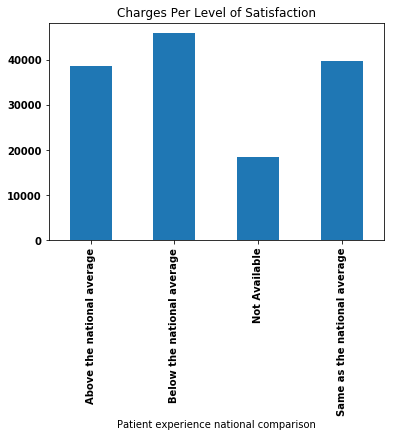

In [32]:
# plot average submitted charges by rating based on customer expriences
Merged_df2[['Patient experience national comparison','Average Estimated Total Submitted Charges']]\
.groupby('Patient experience national comparison').mean().plot(kind='bar',legend=False)
plt.title('Charges Per Level of Satisfaction')

In [33]:
# plot average submitted charges by rating based on customer expriences
#Merged_df2[['Efficient use of medical imaging national comparison','Average Estimated Total Submitted Charges']]\
#.groupby('Efficient use of medical imaging national comparison').mean().plot(kind='bar')
#plt.ylabel("in USD")
#plt.xlabel("Efficient use of medical imaging national comparison")
#plt.title('Hospital Charges by Efficieny of Hospital in Using Medical Imaging')

In [34]:
Merged_df2.isna().sum()

State                                                       0
Provider State                                              0
Provider ID                                                 0
Provider Name                                               0
Provider Street Address                                     0
Provider City                                               0
Provider Zip Code                                           0
Provider HRR                                                0
APC                                                         0
APC Description                                             0
Comprehensive APC Services                                  0
Average Estimated Total Submitted Charges                   0
Average Medicare Allowed Amount                             0
Average Medicare Payment Amount                             0
Outlier Comprehensive APC Services                      10522
Average Medicare Outlier Amount                         24265
County  

In [35]:
### Drop the columns with most missing values 

Merged_df2=Merged_df2.drop(['Outlier Comprehensive APC Services','Average Medicare Outlier Amount'],axis=1)            

In [36]:
Merged_df2.head()

,State,Provider State,Provider ID,Provider Name,Provider Street Address,Provider City,Provider Zip Code,Provider HRR,APC,APC Description,...,Patient experience national comparison,Emergency Services,Effectiveness of care national comparison,Efficient use of medical imaging national comparison,Readmission national comparison,Hospital overall rating,Location,lat_Long,Lat,Long
0,Alabama,AL,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,36301,AL - Dothan,5123,Level 3 Musculoskeletal Procedures,...,Below the national average,True,Same as the national average,Same as the national average,Below the national average,2,"1108 ROSS CLARK CIRCLE DOTHAN, AL 36301 (31.21...","31.214058, -85.361725",31.214058,-85.361725
1,Alabama,AL,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,36301,AL - Dothan,5124,Level 4 Musculoskeletal Procedures,...,Below the national average,True,Same as the national average,Same as the national average,Below the national average,2,"1108 ROSS CLARK CIRCLE DOTHAN, AL 36301 (31.21...","31.214058, -85.361725",31.214058,-85.361725
2,Alabama,AL,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,36301,AL - Dothan,5125,Level 5 Musculoskeletal Procedures,...,Below the national average,True,Same as the national average,Same as the national average,Below the national average,2,"1108 ROSS CLARK CIRCLE DOTHAN, AL 36301 (31.21...","31.214058, -85.361725",31.214058,-85.361725
3,Alabama,AL,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,36301,AL - Dothan,5165,Level 5 ENT Procedures,...,Below the national average,True,Same as the national average,Same as the national average,Below the national average,2,"1108 ROSS CLARK CIRCLE DOTHAN, AL 36301 (31.21...","31.214058, -85.361725",31.214058,-85.361725
4,Alabama,AL,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,36301,AL - Dothan,5191,Level 1 Endovascular Procedures,...,Below the national average,True,Same as the national average,Same as the national average,Below the national average,2,"1108 ROSS CLARK CIRCLE DOTHAN, AL 36301 (31.21...","31.214058, -85.361725",31.214058,-85.361725


In [37]:
# Split Ownership into Goverment, Voluntary-non-profit and Proprietary
#Merged_df2['Hospital Ownership'].str.contains('Voluntary',regex=True)
#Merged_df2[['Ownership_type','ignore1','ignore2']]=Merged_df2['Hospital Ownership'].str.split('-',expand=True)
#Merged_df2.columns

In [38]:
#Merged_df2=Merged_df2.drop(['ignore1','ignore2'],axis=1)

In [39]:
Merged_df2['Hospital Ownership'].unique()

array(['Government - Hospital District or Authority',
       'Voluntary non-profit - Private', 'Proprietary', nan,
       'Government - State', 'Voluntary non-profit - Other',
       'Government - Local', 'Voluntary non-profit - Church',
       'Government - Federal', 'Physician', 'Tribal'], dtype=object)

In [40]:
## get dummies for howpistal ownership
Merged_df2[['Government - Federal', 'Government - Hospital District or Authority',
       'Government - Local', 'Government - State', 'Physician', 'Proprietary',
       'Tribal', 'Voluntary non-profit - Church',
       'Voluntary non-profit - Other', 'Voluntary non-profit - Private']]=pd.get_dummies(Merged_df2['Hospital Ownership'])

In [41]:
# create dummy variables for ownership type

#Merged_df2[['Government','Physician','Proprietary','Tribal','Voluntary non-profit']]=pd.get_dummies(Merged_df2.Ownership_type)

### Let us check if there is quality difference by Ownership type that may explain differences in charges

In [42]:
pd.get_dummies(Merged_df2['Hospital overall rating']).head()

,1,2,3,4,5,Not Available
0,0,1,0,0,0,0
1,0,1,0,0,0,0
2,0,1,0,0,0,0
3,0,1,0,0,0,0
4,0,1,0,0,0,0


In [43]:
# create dummy variables for overall rating(Star Level)
Merged_df2[['star_1','star_2','star_3','star_4','star_5','not_available']]=pd.get_dummies(pd.get_dummies(Merged_df2['Hospital overall rating']))
                                                                                          
                                                                                          

## Except for Star_3,mean charge decreased as we move from lower star to higher star hospitals.

Text(0.5,1,'Hospital Charge By Over All Rating')

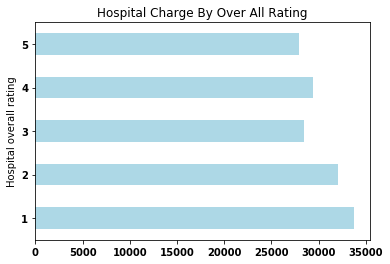

In [44]:
# plot charges by Hospital Overall rating.
Merged_df2[['Hospital overall rating','Average Estimated Total Submitted Charges']]\
.groupby('Hospital overall rating').median().drop('Not Available',axis=0).plot(kind='barh',legend=False,color='lightblue')
plt.title('Hospital Charge By Over All Rating')

In [45]:
# create dummy variables for ownership type
Merged_df2[['Above the national average','Below the national average',
            'Not Available','Same as the national average']]=pd.get_dummies(Merged_df2['Effectiveness of care national comparison'])

Qaulity_ownership_4=Merged_df2[['Hospital Ownership','Above the national average','Below the national average',
                              'Not Available','Same as the national average']].groupby('Hospital Ownership').sum()

Qaulity_ownership_4['Total_Ownership_category']=Qaulity_ownership_4[Qaulity_ownership_4.columns].sum(axis=1)
# Effectiveness of care by Ownership type
Qaulity_in_percent_4=Qaulity_ownership_4.iloc[:,0:-1].div(Qaulity_ownership_4.iloc[:,4], axis=0).round(2)*100
# drop Tribal and display
#Qaulity_in_percent_4=Qaulity_in_percent_4.drop('Tribal',axis=0)
Qaulity_in_percent_4['Same or Above National Average']=Qaulity_in_percent_4.iloc[:,0]+Qaulity_in_percent_4.iloc[:,3]
Qaulity_in_percent_4

,Above the national average,Below the national average,Not Available,Same as the national average,Same or Above National Average
Hospital Ownership,,,,,
Government - Federal,0.0,12.0,0.0,88.0,88.0
Government - Hospital District or Authority,2.0,13.0,0.0,84.0,86.0
Government - Local,3.0,9.0,0.0,88.0,91.0
Government - State,7.0,13.0,2.0,79.0,86.0
Physician,0.0,4.0,21.0,75.0,75.0
Proprietary,11.0,4.0,2.0,83.0,94.0
Tribal,0.0,0.0,0.0,100.0,100.0
Voluntary non-profit - Church,6.0,12.0,0.0,82.0,88.0
Voluntary non-profit - Other,9.0,7.0,1.0,83.0,92.0


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

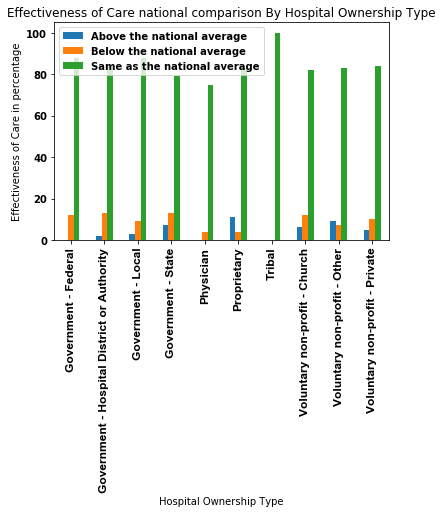

In [46]:
# Effectiveness of care  by types of ownership
Qaulity_in_percent_4[['Above the national average','Below the national average','Same as the national average']].plot(kind='bar')
plt.ylabel("Effectiveness of Care in percentage")
plt.xlabel("Hospital Ownership Type")
plt.title("Effectiveness of Care national comparison By Hospital Ownership Type")
plt.xticks(fontname="Arial", fontsize=12)

(array([ 0.,  2.,  4.,  6.,  8., 10., 12.]),
 <a list of 7 Text xticklabel objects>)

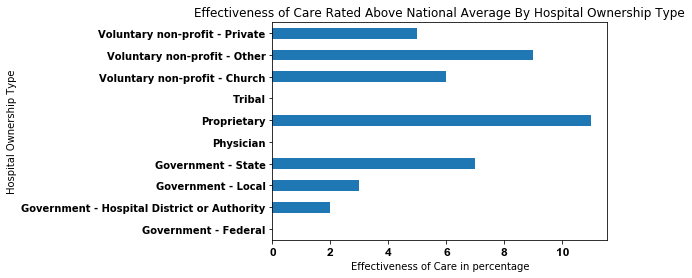

In [47]:
# Effectiveness of care  by types of ownership
Qaulity_in_percent_4[['Above the national average']].plot(kind='barh',legend=False)
plt.xlabel("Effectiveness of Care in percentage")
plt.ylabel("Hospital Ownership Type")
plt.title("Effectiveness of Care Rated Above National Average By Hospital Ownership Type")
plt.xticks(fontname="Arial", fontsize=12)

### State Government Hospitals have least readmission rate, followed by Federal Government Hospitals
### Physicians services the highest readmission rate, followed by Voluntary non-profit - Church hospitals

In [48]:
# create dummy variables for ownership type
Merged_df2[['Above the national average','Below the national average',
            'Not Available','Same as the national average']]=pd.get_dummies(Merged_df2['Readmission national comparison'])

Qaulity_ownership_3=Merged_df2[['Hospital Ownership','Above the national average','Below the national average',
                              'Not Available','Same as the national average']].groupby('Hospital Ownership').sum()

Qaulity_ownership_3['Total_Ownership_category']=Qaulity_ownership_3[Qaulity_ownership_3.columns].sum(axis=1)
# Readmision by Ownership type
Qaulity_in_percent_3=Qaulity_ownership_3.iloc[:,0:-1].div(Qaulity_ownership_3.iloc[:,4], axis=0).round(2)*100
# drop Tribal and display
Qaulity_in_percent_3=Qaulity_in_percent_3.drop('Tribal',axis=0)
Qaulity_in_percent_3['Same or Below National Average']=Qaulity_in_percent_3.iloc[:,1]+Qaulity_in_percent_3.iloc[:,3]
Qaulity_in_percent_3

,Above the national average,Below the national average,Not Available,Same as the national average,Same or Below National Average
Hospital Ownership,,,,,
Government - Federal,28.0,47.0,2.0,23.0,70.0
Government - Hospital District or Authority,43.0,43.0,1.0,13.0,56.0
Government - Local,46.0,36.0,1.0,18.0,54.0
Government - State,24.0,67.0,1.0,9.0,76.0
Physician,34.0,20.0,34.0,13.0,33.0
Proprietary,32.0,53.0,3.0,11.0,64.0
Voluntary non-profit - Church,60.0,31.0,0.0,9.0,40.0
Voluntary non-profit - Other,53.0,35.0,2.0,10.0,45.0
Voluntary non-profit - Private,49.0,43.0,1.0,8.0,51.0


Text(0.5,1,'Readmission national comparison By Hospital Ownership Type')

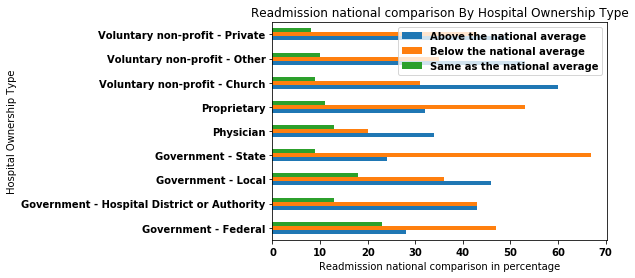

In [49]:
# readmission  by types of ownership
Qaulity_in_percent_3[['Above the national average','Below the national average','Same as the national average']].plot(kind='barh')
plt.xlabel("Readmission national comparison in percentage")
plt.ylabel("Hospital Ownership Type")
plt.title("Readmission national comparison By Hospital Ownership Type")

Text(0.5,1,'Readmission Rated Below National Average By Hospital Ownership Type')

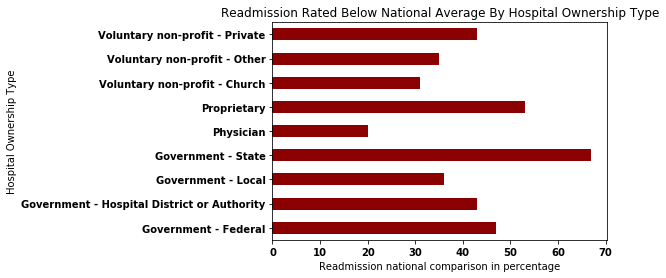

In [50]:
# readmission  by types of ownership
Qaulity_in_percent_3[['Below the national average']].plot(kind='barh',legend=False,color='darkred')
plt.xlabel("Readmission national comparison in percentage")
plt.ylabel("Hospital Ownership Type")
plt.title("Readmission Rated Below National Average By Hospital Ownership Type")


### Propreitary Hospitals Tends to use Medical Imaging More than other categories(Less efficient) 
### Federal Government is least user of Medical Imaging(Most Efficient)

In [51]:
# create dummy variables for ownership type
Merged_df2[['Above the national average','Below the national average',
            'Not Available','Same as the national average']]=pd.get_dummies(Merged_df2['Efficient use of medical imaging national comparison'])

Qaulity_ownership_2=Merged_df2[['Hospital Ownership','Above the national average','Below the national average',
                              'Not Available','Same as the national average']].groupby('Hospital Ownership').sum()

Qaulity_ownership_2['Total_Ownership_category']=Qaulity_ownership_2[Qaulity_ownership_2.columns].sum(axis=1)
# Medical Imaging rating by Ownership type
Qaulity_in_percent_2=Qaulity_ownership_2.iloc[:,0:-1].div(Qaulity_ownership_2.iloc[:,4], axis=0).round(2)*100
# drop Tribal and display
Qaulity_in_percent_2=Qaulity_in_percent_2.drop('Tribal',axis=0)
Qaulity_in_percent_2

,Above the national average,Below the national average,Not Available,Same as the national average
Hospital Ownership,,,,
Government - Federal,48.0,10.0,2.0,40.0
Government - Hospital District or Authority,22.0,19.0,4.0,56.0
Government - Local,20.0,21.0,6.0,54.0
Government - State,26.0,25.0,2.0,47.0
Physician,0.0,22.0,59.0,19.0
Proprietary,17.0,15.0,11.0,57.0
Voluntary non-profit - Church,25.0,14.0,1.0,60.0
Voluntary non-profit - Other,25.0,13.0,4.0,59.0
Voluntary non-profit - Private,24.0,15.0,3.0,58.0


Text(0.5,1,'Efficiency of Medical Imaging By Hospital Ownership Type')

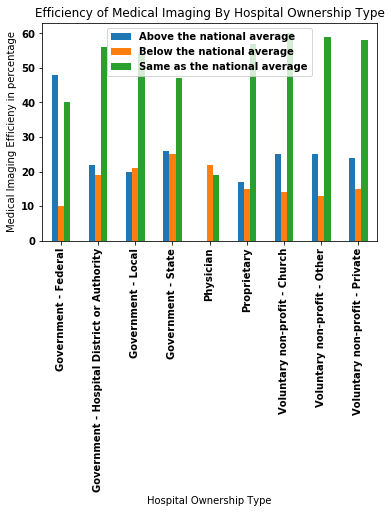

In [52]:
# Medical Imaging by types of ownership
Qaulity_in_percent_2[['Above the national average','Below the national average','Same as the national average']].plot(kind='bar')
plt.ylabel("Medical Imaging Efficieny in percentage")
plt.xlabel("Hospital Ownership Type")
plt.title("Efficiency of Medical Imaging By Hospital Ownership Type")

In [53]:
# create dummy variables for ownership type
Merged_df2[['Above the national average','Below the national average',
            'Not Available','Same as the national average']]=pd.get_dummies(Merged_df2['Patient experience national comparison'])

In [54]:
Qaulity_ownership=Merged_df2[['Hospital Ownership','Above the national average','Below the national average',
                              'Not Available','Same as the national average']].groupby('Hospital Ownership').sum()

### The patient expreince by percentage  

In [55]:
Qaulity_ownership['Total_Ownership_category']=Qaulity_ownership[Qaulity_ownership.columns].sum(axis=1)
# Patient Expreince rating by Ownership type
Qaulity_in_percent=Qaulity_ownership.iloc[:,0:-1].div(Qaulity_ownership.iloc[:,4], axis=0).round(2)*100
# drop Tribal and display
Qaulity_in_percent=Qaulity_in_percent.drop('Tribal',axis=0)
Qaulity_in_percent

,Above the national average,Below the national average,Not Available,Same as the national average
Hospital Ownership,,,,
Government - Federal,2.0,37.0,0.0,62.0
Government - Hospital District or Authority,28.0,40.0,3.0,29.0
Government - Local,32.0,34.0,2.0,32.0
Government - State,51.0,27.0,1.0,21.0
Physician,70.0,9.0,7.0,14.0
Proprietary,17.0,57.0,1.0,25.0
Voluntary non-profit - Church,33.0,32.0,0.0,34.0
Voluntary non-profit - Other,36.0,30.0,0.0,33.0
Voluntary non-profit - Private,34.0,32.0,0.0,34.0


### Highest Level of Satisfactions of Patient with Physicians and State Hospitals 
### This may imply, it would be an appropirate Policy direction to give more authority on healthcare investment and administration to States

Text(0.5,1,'Patient Satisfaction By Hospital Ownership Type')

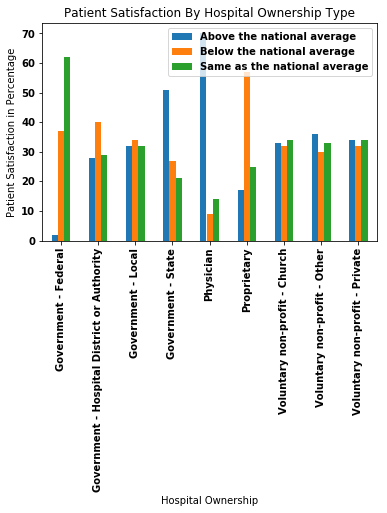

In [56]:
# patient Experience by types of ownership
Qaulity_in_percent[['Above the national average','Below the national average','Same as the national average']].plot(kind='bar')
plt.ylabel("Patient Satisfaction in Percentage")
plt.title("Patient Satisfaction By Hospital Ownership Type")

Text(0.5,1,'Patient Satisfaction Rated Above National Average By Hospital Ownership Type')

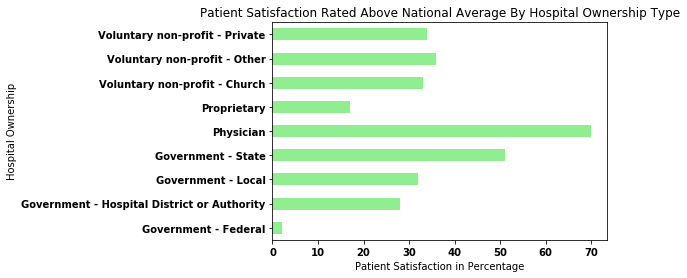

In [57]:
# patient Experience by types of ownership
Qaulity_in_percent[['Above the national average']].plot(kind='barh',legend=False,color='lightgreen')
plt.xlabel("Patient Satisfaction in Percentage")
plt.title("Patient Satisfaction Rated Above National Average By Hospital Ownership Type")

### Implantable Cardioverter Defibrillator (ICD) Procedures is at the top of charges : median charge is about $116372.42
### ICD is used to monitor and control heart in patients that had critical heart attacks 
### The next high charge was for Level6 ENT procedures(Ear ,Nose and Throat surgery)
### Procedures related to comprehensive general obsevations, lower level electrophycological procedures , gynocology and urology are at bottom of charges. 

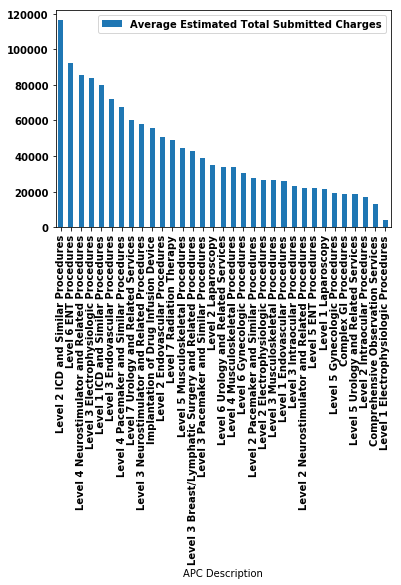

In [58]:
# plot median charge by APC Procedures
Merged_df2[['APC Description','Average Estimated Total Submitted Charges']]\
.groupby('APC Description').median().sort_values('Average Estimated Total Submitted Charges',ascending=False)\
.plot(kind='bar')

###  map Hospital charge and Informations

### - map all hospitals against overall median charges for outpatient charges in 2016
       used choropleth for this.
### - map for ICD procedures map using against ICD median charges
### - map for comprehensive obseervation services

In [59]:
Merged_df2[['Average Estimated Total Submitted Charges']].median()

Average Estimated Total Submitted Charges    29937.882434
dtype: float64

In [60]:
Counter(Merged_df2['APC Description'])

Counter({'Complex GI Procedures': 441,
         'Comprehensive Observation Services': 2882,
         'Implantation of Drug Infusion Device': 134,
         'Level 1 Electrophysiologic Procedures': 12,
         'Level 1 Endovascular Procedures': 1482,
         'Level 1 ICD and Similar Procedures': 468,
         'Level 1 Laparoscopy': 2499,
         'Level 2 Electrophysiologic Procedures': 252,
         'Level 2 Endovascular Procedures': 1687,
         'Level 2 ICD and Similar Procedures': 1052,
         'Level 2 Intraocular Procedures': 691,
         'Level 2 Laparoscopy': 1076,
         'Level 2 Neurostimulator and Related Procedures': 411,
         'Level 2 Pacemaker and Similar Procedures': 1008,
         'Level 3 Breast/Lymphatic Surgery and Related Procedures': 122,
         'Level 3 Electrophysiologic Procedures': 830,
         'Level 3 Endovascular Procedures': 1120,
         'Level 3 Intraocular Procedures': 4,
         'Level 3 Musculoskeletal Procedures': 2358,
         'Level 

In [61]:
# filter Comprehensive Observation Services Procedures from the data
Merged_df3=Merged_df2[Merged_df2['APC Description']=='Comprehensive Observation Services']
# keep only columns wanted be popped up in the map and group by Provider Name and County, Lat  and Long and calculate median
Merged_df3=Merged_df3[['State','Provider HRR','Hospital Ownership','Average Estimated Total Submitted Charges','Lat','Long']]\
        .groupby(['State','Provider HRR','Hospital Ownership','Lat','Long']).median()\
        .reset_index()

In [62]:
# find overall median charge for ICD and Similar Procedures
median_chargeCompObs=Merged_df2[Merged_df2['APC Description']=='Comprehensive Observation Services']\
                                                              ['Average Estimated Total Submitted Charges'].median()
median_chargeCompObs=pd.to_numeric(median_chargeCompObs)
median_chargeCompObs=round(median_chargeCompObs,2)

In [63]:
115525.388519813

115525.388519813

In [64]:
# Filter only Implantable Cardioverter Defibrillator (ICD) Procedures
# It is used to monitor and control heart in patients that had critical heart attacks 
Merged_df4=Merged_df2[Merged_df2['APC Description']=='Level 2 ICD and Similar Procedures']

# keep only columns wanted be popped up in the map and group by Provider Name and County, Lat  and Long and calculate median
Merged_df4=Merged_df4[['State','Provider HRR','Hospital Ownership','Average Estimated Total Submitted Charges','Lat','Long']]\
        .groupby(['State','Provider HRR','Hospital Ownership','Lat','Long']).median()\
        .reset_index()

In [65]:
# find overall median charge for ICD and Similar Procedures
median_chargeICD=Merged_df2[Merged_df2['APC Description']=='Level 2 ICD and Similar Procedures']['Average Estimated Total Submitted Charges'].median()
median_chargeICD=pd.to_numeric(median_chargeICD)
round(median_chargeICD,2)

116372.42

In [66]:
Merged_df4.head()

,State,Provider HRR,Hospital Ownership,Lat,Long,Average Estimated Total Submitted Charges
0,Alabama,AL - Birmingham,Government - Hospital District or Authority,32.638055,-85.404003,53929.279032
1,Alabama,AL - Birmingham,Government - Hospital District or Authority,34.79366,-87.684348,150351.187097
2,Alabama,AL - Birmingham,Government - Local,33.657123,-85.823353,152827.888750
3,Alabama,AL - Birmingham,Government - State,33.506129,-86.801922,87491.228539
4,Alabama,AL - Birmingham,Proprietary,33.434363,-86.720483,512630.392500


In [67]:
### reassing Merged_df3 to mapCompObs_df and drop missing, and convert Lat and Long to numeric
mapCompObs_df=Merged_df3
mapCompObs_df=mapCompObs_df.dropna(axis=0)
mapCompObs_df['Lat']=pd.to_numeric(mapCompObs_df.Lat)
mapCompObs_df['Long']=pd.to_numeric(mapCompObs_df.Long)

In [68]:
### reassing Merged_df4 to Merged_df_map and drop missing, and convert Lat and Long to numeric
Merged_df_map=Merged_df4
Merged_df_map=Merged_df_map.dropna(axis=0)
Merged_df_map['Lat']=pd.to_numeric(Merged_df_map.Lat)
Merged_df_map['Long']=pd.to_numeric(Merged_df_map.Long)
Merged_df_map['Average Estimated Total Submitted Charges']= Merged_df_map['Average Estimated Total Submitted Charges'].round(2)
Merged_df_map.head()

,State,Provider HRR,Hospital Ownership,Lat,Long,Average Estimated Total Submitted Charges
0,Alabama,AL - Birmingham,Government - Hospital District or Authority,32.638055,-85.404003,53929.28
1,Alabama,AL - Birmingham,Government - Hospital District or Authority,34.793660,-87.684348,150351.19
2,Alabama,AL - Birmingham,Government - Local,33.657123,-85.823353,152827.89
3,Alabama,AL - Birmingham,Government - State,33.506129,-86.801922,87491.23
4,Alabama,AL - Birmingham,Proprietary,33.434363,-86.720483,512630.39


In [69]:
import plotly
import plotly.plotly as py
import plotly.tools as tls
import plotly.graph_objs as go

tls.set_credentials_file(username='asidamo', api_key='mKLD0mhVoFbiAx3Z0qZW')

In [70]:
state_loc=pd.read_csv('data/statelatlong.csv')

state_loc.shape

(51, 4)

In [71]:
state_loc.head()

,State,Latitude,Longitude,City
0,AL,32.601011,-86.680736,Alabama
1,AK,61.302501,-158.775020,Alaska
2,AZ,34.168219,-111.930907,Arizona
3,AR,34.751928,-92.131378,Arkansas
4,CA,37.271875,-119.270415,California


In [72]:
state_loc.columns=['State_abbr','Lat,','Long','State']

In [73]:
#group the data by State
State_median= Merged_df2[['State','Average Estimated Total Submitted Charges']].groupby(['State']).mean()

In [74]:
Median_State_charge=pd.merge(State_median,state_loc,how='left',on='State')
Median_State_charge.head()

,State,Average Estimated Total Submitted Charges,State_abbr,"Lat,",Long
0,Alabama,43329.469986,AL,32.601011,-86.680736
1,Alaska,43464.792294,AK,61.302501,-158.775020
2,Arizona,49995.416997,AZ,34.168219,-111.930907
3,Arkansas,34818.805155,AR,34.751928,-92.131378
4,California,57271.173063,CA,37.271875,-119.270415


In [75]:
df = Median_State_charge ## pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2011_us_ag_exports.csv')

for col in df.columns:
    df[col] = df[col].astype(str)

scl = [[0.0, 'rgb(242,240,247)'],[0.2, 'rgb(218,218,235)'],[0.4, 'rgb(188,189,220)'],\
            [0.6, 'rgb(158,154,200)'],[0.8, 'rgb(117,107,177)'],[1.0, 'rgb(84,39,143)']]

df['text'] = df['State'] 

data = [ dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = df['State_abbr'],
        z = df['Average Estimated Total Submitted Charges'].astype(float),
        locationmode = 'USA-states',
        text = df['text'],
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            )
        ),
        colorbar = dict(
            title = " Average Hospital Charge in USD"
        )
    ) ]

layout = dict(
        title = 'Average Hospital Charge for Medicare Outpatients in 2016',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)',
        ),
    )

fig = dict(data=data, layout=layout)

url = py.plot(fig, filename='d3-cloropleth-map')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~asidamo/0 or inside your plot.ly account where it is named 'd3-cloropleth-map'


In [76]:
   # Full derates to map
map_df = Merged_df_map# Merged_df_map.State=='Tennessee']
    #create our map of the world and show it
map_world = folium.Map(location = [36.1627,-86.78], zoom_start = 5)

# draw our plate boundaries: plate_bounds
# folium.GeoJson(plate_bounds).add_to(map_world)

#iterate through map_df to create locations and markers for each piece

for row in map_df.iterrows():
    row_values = row[1] 
    location = [row_values['Lat'], row_values['Long']]
    popup ='Referral Region: ' + str(row_values['Provider HRR']) + '<br/>' + 'Ownership: ' + str(row_values['Hospital Ownership']) + '<br/>'+ 'APC Procedure: ' + 'Level2 ICD and Similar Procedures' + '<br/>'+'Median Hospital Charge: ' + str(row_values['Average Estimated Total Submitted Charges'])

#marker = folium.Marker(location = location, popup = popup)
#         marker = folium.Circle(location=location, popup=popup, radius=mag_radius, color='crimson', fill=False, fill_color='crimson').add_to(map_world)
#         marker.add_to(map_world)

    charge = row_values['Average Estimated Total Submitted Charges']
    if charge >150000:
        color = 'red'
    elif charge > median_chargeICD:# median hospital charge for Implantable Cardioverter Defibrillator (ICD) is $116525

        color = 'yellow'
    else:
        color = 'green'
    marker = folium.Circle(location=location, popup=popup, radius=20000, color=color, fill=False, fill_color=color)# .add_to(map_world)
    marker.add_to(map_world)

# Show map
map_world

In [77]:
#Merged_df_map[~Merged_df_map.Lat.str.contains("...") == True]

## Below functions helps us to map state by state

In [78]:
# create state list
state_list=Merged_df_map['State'].unique().tolist()

In [79]:
def f(x):
    
    # Full derates to map
    map_df = Merged_df_map[Merged_df_map.State==x]
  
    #create our map of the world and show it
    map_world = folium.Map(location = [36.1627,-86.78], zoom_start = 5)

    # draw our plate boundaries: plate_bounds
    # folium.GeoJson(plate_bounds).add_to(map_world)
        
    for row in map_df.iterrows():
        row_values = row[1] 
        location = [row_values['Lat'], row_values['Long']]
        popup ='Referral Region: ' + str(row_values['Provider HRR']) + '<br/>' + 'Ownership: ' + str(row_values['Hospital Ownership']) + '<br/>'+ 'APC Procedure: ' + 'Level2 ICD and Similar Procedures' + '<br/>'+'Median Hospital Charge: ' + str(row_values['Average Estimated Total Submitted Charges'])
    
    #for row in map_df.iterrows():
    #    row_values = row[1] 
    #    location = [row_values['Lat'], row_values['Long']]
    #    popup ='State: ' + x + '<br/>' + 'APC Procedure: ' + 'Level 2 ICD and Similar Procedures' + '<br/>' +  'Median Hospital Charge: ' + str(row_values['Average Estimated Total Submitted Charges'])
             
        #marker = folium.Marker(location = location, popup = popup)
    
    #         marker = folium.Circle(location=location, popup=popup, radius=mag_radius, color='crimson', fill=False, fill_color='crimson').add_to(map_world)
    #         marker.add_to(map_world)
   
        charge = row_values['Average Estimated Total Submitted Charges']
        if charge >150000:
            color = 'red'
        elif charge > median_chargeICD:# median hospital charge for Implantable Cardioverter Defibrillator (ICD) is $115525.39
            color = 'yellow'
        else:
            color = 'green'
        marker = folium.Circle(location=location, popup=popup, radius=20000, color=color, fill=False, fill_color=color)# .add_to(map_world)
        marker.add_to(map_world)

   
    return map_world

In [80]:
# this part interacts and filters only one State

interact(f, x=state_list);

interactive(children=(Dropdown(description='x', options=('Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'District of Columbia', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming'), value='Alabama'), Output()), _dom_classes=('widget-interact',))

In [81]:
procedures=Merged_df2['APC Description'].unique().tolist()

# this part interacts and filters only one State

interact(f, x=state_list,y=procedures);

In [82]:
# replace level  and level numbers
# replace text level with blank
Merged_df2['ProcedureName']=Merged_df2['APC Description'].str.replace('Level','')

# create a new column called level, to control the complexity of treatments
Merged_df2['Level'] = Merged_df2['APC Description'].str.extract('(\d)', expand=True)


In [83]:
# replace numbers with blank
Merged_df2['ProcedureName']=Merged_df2['ProcedureName'].replace('\d+','',regex=True)

# check spaces and then we will trim them 

Merged_df2['ProcedureName'].unique()

array(['  Musculoskeletal Procedures', '  ENT Procedures',
       '  Endovascular Procedures', '  Pacemaker and Similar Procedures',
       '  ICD and Similar Procedures', 'Complex GI Procedures',
       '  Laparoscopy', '  Urology and Related Services',
       '  Gynecologic Procedures',
       '  Neurostimulator and Related Procedures',
       '  Intraocular Procedures', '  Radiation Therapy',
       'Comprehensive Observation Services',
       '  Electrophysiologic Procedures',
       '  Breast/Lymphatic Surgery and Related Procedures',
       'Implantation of Drug Infusion Device'], dtype=object)

In [84]:
# remove space at beginning from colum values using str.strip
Merged_df2['ProcedureName']=Merged_df2['ProcedureName'].str.strip()
Merged_df2['ProcedureName'].unique()

array(['Musculoskeletal Procedures', 'ENT Procedures',
       'Endovascular Procedures', 'Pacemaker and Similar Procedures',
       'ICD and Similar Procedures', 'Complex GI Procedures',
       'Laparoscopy', 'Urology and Related Services',
       'Gynecologic Procedures', 'Neurostimulator and Related Procedures',
       'Intraocular Procedures', 'Radiation Therapy',
       'Comprehensive Observation Services',
       'Electrophysiologic Procedures',
       'Breast/Lymphatic Surgery and Related Procedures',
       'Implantation of Drug Infusion Device'], dtype=object)

In [85]:
# convert level to nmeric data type
Merged_df2['Level']=pd.to_numeric(Merged_df2.Level)

In [86]:
Merged_df2.Level.dtype

dtype('float64')

### Nevada is at top in terms of  median hospital charge: median hospital charge $48532.31

### Followed by Florida ,median charge ($46254.79)

In [87]:
# calculate mean average charges by States
Merged_df2[['State','Average Estimated Total Submitted Charges']]\
.groupby('State').mean().sort_values('Average Estimated Total Submitted Charges',ascending=False).round(2).head(5)

,Average Estimated Total Submitted Charges
State,
Nevada,61441.23
California,57271.17
Florida,56519.27
Colorado,51569.53
Arizona,49995.42


Text(0.5,1,'Median Average Estimated Total Charge By States for Level3 Endovascular Procedures')

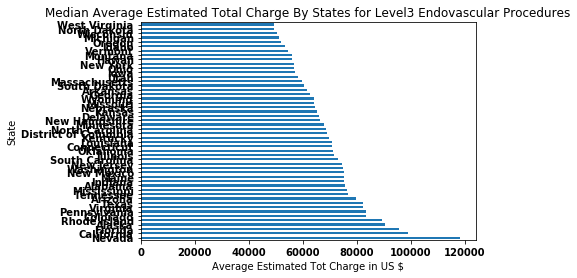

In [88]:
# median Average charge by State
Merged_df2[Merged_df2['APC Description']=='Level 3 Endovascular Procedures']\
[['State','Average Estimated Total Submitted Charges']]\
.groupby('State').median().sort_values('Average Estimated Total Submitted Charges',ascending=False).round(2).plot(kind='barh',legend=False)
plt.xlabel('Average Estimated Tot Charge in US $')
plt.title('Median Average Estimated Total Charge By States for Level3 Endovascular Procedures')

Text(0.5,0,'amount in US $')

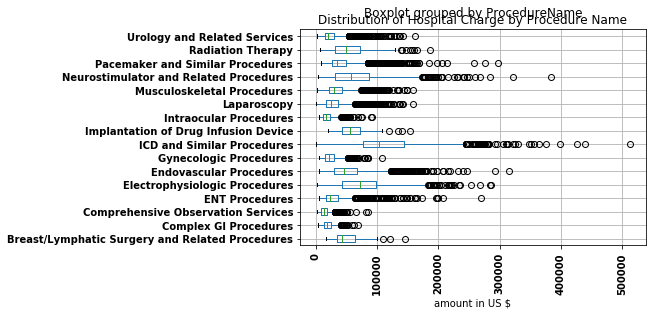

In [89]:
charge_by_proc=Merged_df2[['ProcedureName','Average Estimated Total Submitted Charges']]


charge_by_proc.boxplot(column='Average Estimated Total Submitted Charges',by='ProcedureName',vert=False)
plt.xticks(rotation='vertical')
plt.title("Distribution of Hospital Charge by Procedure Name")
plt.xlabel("amount in US $")


Text(0.5,0,'amount in US $')

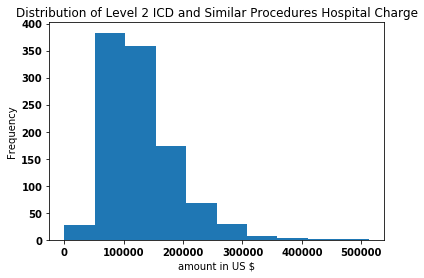

In [90]:
Merged_df2[Merged_df2['APC Description']=='Level 2 ICD and Similar Procedures']\
['Average Estimated Total Submitted Charges'].plot(kind='hist')
plt.title("Distribution of Level 2 ICD and Similar Procedures Hospital Charge")
plt.xlabel('amount in US $')

Text(0.5,1,'Median Average Estimated Total Charge By States for Level 2 ICD and Similar Procedures')

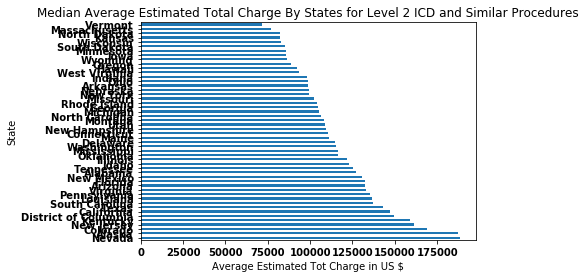

In [91]:
# median Average charge by State
Merged_df2[Merged_df2['APC Description']=='Level 2 ICD and Similar Procedures']\
[['State','Average Estimated Total Submitted Charges']]\
.groupby('State').median().sort_values('Average Estimated Total Submitted Charges',ascending=False).round(2).plot(kind='barh',legend=False)
plt.xlabel('Average Estimated Tot Charge in US $')
plt.title('Median Average Estimated Total Charge By States for Level 2 ICD and Similar Procedures')

Text(0.5,0,'# of Comprehensive APC Services')

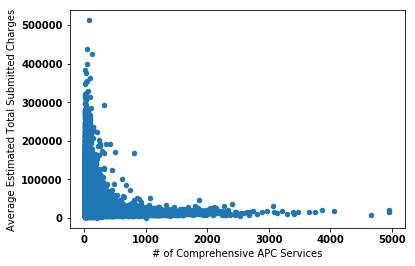

In [92]:
#plot number of services provided vs average hospital charge by provider
Merged_df2.plot(x='Comprehensive APC Services',y='Average Estimated Total Submitted Charges',kind="scatter")
plt.xlabel('# of Comprehensive APC Services')

In [93]:
# remove space at beginning from colum values using regex
#merged_df['ProcedureName']=merged_df['ProcedureName'].replace('^\s+','',regex=True)
#merged_df['ProcedureName'].unique()

In [94]:
# remove space at end from colum values
#merged_df['ProcedureName']=merged_df['ProcedureName'].replace('\s+$','',regex=True)
#merged_df['ProcedureName'].unique()

In [95]:
# calculate the difference between the average estimated total sumbitted charges and 
#merged_df['submitted_allowed_diff']=(merged_df['Average Estimated Total Submitted Charges']-merged_df['Average Medicare Allowed Amount'])

In [96]:
#merged_df['submitted_allowed_diff'].sum()


In [97]:
# create Tennessee and FLorida
#OutPatmedicarecharge_TN=merged_df[merged_df['Provider State'].str.contains('TN')]
#OutPatmedicarecharge_FL=merged_df[merged_df['Provider State'].str.contains('FL')]

# distribution
#OutPatmedicarecharge_heartProc=OutPatmedicarecharge_TN[OutPatmedicarecharge_TN['APC Description']=='Level 3 Endovascular Procedures']
#OutPatmedicarecharge_heartProc.iloc[:,12:15].plot(kind='box')
#plt.title('Distribution of Outpatient Charges by Hospitals for Level 3 Endovascular Procedures in Tennessee')
#plt.ylabel("amount in US $")


In [98]:
# show distribution of charges by each APC procedures

def f(x):
    OutPatmedicarecharge_heartProc=Merged_df2[Merged_df2['APC Description']==x]
    OutPatmedicarecharge_heartProc.iloc[:,11:14].plot(kind='box')
    plot_proc=plt.title('Distribution of Outpatient Charges by Hospitals for Level 3 Endovascular Procedures in USA')
    plt.ylabel("amount in US $")
    
    return plot_proc

In [99]:
interact(f, x=procedures);

interactive(children=(Dropdown(description='x', options=('Level 3 Musculoskeletal Procedures', 'Level 4 Musculoskeletal Procedures', 'Level 5 Musculoskeletal Procedures', 'Level 5 ENT Procedures', 'Level 1 Endovascular Procedures', 'Level 2 Endovascular Procedures', 'Level 3 Endovascular Procedures', 'Level 2 Pacemaker and Similar Procedures', 'Level 3 Pacemaker and Similar Procedures', 'Level 1 ICD and Similar Procedures', 'Level 2 ICD and Similar Procedures', 'Complex GI Procedures', 'Level 1 Laparoscopy', 'Level 2 Laparoscopy', 'Level 5 Urology and Related Services', 'Level 7 Urology and Related Services', 'Level 5 Gynecologic Procedures', 'Level 2 Neurostimulator and Related Procedures', 'Level 2 Intraocular Procedures', 'Level 7 Radiation Therapy', 'Comprehensive Observation Services', 'Level 3 Neurostimulator and Related Procedures', 'Level 3 Electrophysiologic Procedures', 'Level 6 Urology and Related Services', 'Level 6 ENT Procedures', 'Level 4 Neurostimulator and Related Procedures', 'Level 2 Electrophysiologic Procedures', 'Level 6 Gynecologic Procedures', 'Level 3 Breast/Lymphatic Surgery and Related Procedures', 'Level 4 Pacemaker and Similar Procedures', 'Implantation of Drug Infusion Device', 'Level 1 Electrophysiologic Procedures', 'Level 3 Intraocular Procedures'), value='Level 3 Musculoskeletal Procedures'), Output()), _dom_classes=('widget-interact',))

In [100]:
# show distribution of charges by each APC procedures
def f(x,y):
    OutPatmedicarecharge_heartProc=Merged_df2[(Merged_df2['State']==x) &(Merged_df2['APC Description']==y)]
    OutPatmedicarecharge_heartProc.iloc[:,11].plot(kind='hist')
    plot_proc_by_state=plt.title('Distribution of Outpatient Charges by State and Procedure Type')
    plt.ylabel("amount in US $")
    
    return plot_proc_by_state

In [101]:
interact(f,x=state_list, y=procedures);

interactive(children=(Dropdown(description='x', options=('Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'District of Columbia', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming'), value='Alabama'), Dropdown(description='y', options=('Level 3 Musculoskeletal Procedures', 'Level 4 Musculoskeletal Procedures', 'Level 5 Musculoskeletal Procedures', 'Level 5 ENT Procedures', 'Level 1 Endovascular Procedures', 'Level 2 Endovascular Procedures', 'Level 3 Endovascular Procedures', 'Level 2 Pacemaker and Similar Procedures', 'Level 3 Pacemaker and Similar Procedures', 'Level 1 ICD and Similar Procedures', 'Level 2 ICD and Similar Procedures', 'Complex GI Procedures', 'Level 1 Laparoscopy', 'Level 2 Laparoscopy', 'Level 5 Urology and Related Services', 'Level 7 Urology and Related Services', 'Level 5 Gynecologic Procedures', 'Level 2 Neurostimulator and Related Procedures', 'Level 2 Intraocular Procedures', 'Level 7 Radiation Therapy', 'Comprehensive Observation Services', 'Level 3 Neurostimulator and Related Procedures', 'Level 3 Electrophysiologic Procedures', 'Level 6 Urology and Related Services', 'Level 6 ENT Procedures', 'Level 4 Neurostimulator and Related Procedures', 'Level 2 Electrophysiologic Procedures', 'Level 6 Gynecologic Procedures', 'Level 3 Breast/Lymphatic Surgery and Related Procedures', 'Level 4 Pacemaker and Similar Procedures', 'Implantation of Drug Infusion Device', 'Level 1 Electrophysiologic Procedures', 'Level 3 Intraocular Procedures'), value='Level 3 Musculoskeletal Procedures'), Output()), _dom_classes=('widget-interact',))

In [102]:
# plot by Providers Name
def f(x):
    Merged_df_Provider=Merged_df2[Merged_df2['State']==x].reset_index()
    Merged_df_Provider=Merged_df_Provider[['State','Provider Name','Average Estimated Total Submitted Charges']].groupby(['Provider Name','State']).median().sort_values('Average Estimated Total Submitted Charges',ascending=False)
    Merged_df_Provider=Merged_df_Provider.head(20).reset_index()
    plot_provider=plt.bar(x=Merged_df_Provider['Provider Name'],height= Merged_df_Provider['Average Estimated Total Submitted Charges'])
    plt.xticks(rotation='vertical')
    plt.ylabel('amount in US $')

    return plot_provider

In [103]:
interact(f,x=state_list);

interactive(children=(Dropdown(description='x', options=('Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'District of Columbia', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming'), value='Alabama'), Output()), _dom_classes=('widget-interact',))

In [104]:
Merged_df2.columns

Index(['State', 'Provider State', 'Provider ID', 'Provider Name',
       'Provider Street Address', 'Provider City', 'Provider Zip Code',
       'Provider HRR', 'APC', 'APC Description', 'Comprehensive APC Services',
       'Average Estimated Total Submitted Charges',
       'Average Medicare Allowed Amount', 'Average Medicare Payment Amount',
       'County', 'Hospital Type', 'Hospital Ownership',
       'Patient experience national comparison', 'Emergency Services',
       'Effectiveness of care national comparison',
       'Efficient use of medical imaging national comparison',
       'Readmission national comparison', 'Hospital overall rating',
       'Location', 'lat_Long', 'Lat', 'Long', 'Government - Federal',
       'Government - Hospital District or Authority', 'Government - Local',
       'Government - State', 'Physician', 'Proprietary', 'Tribal',
       'Voluntary non-profit - Church', 'Voluntary non-profit - Other',
       'Voluntary non-profit - Private', 'star_1', 'star_2

In [105]:
# plot charges by Providers and Procedures
def f(x):
    Merged_df_Provider=Merged_df2[Merged_df2['State']==x]
    Merged_df_Provider_1=Merged_df_Provider[['State','ProcedureName','Average Estimated Total Submitted Charges']]\
                         .groupby(['State','ProcedureName']).median().sort_values('Average Estimated Total Submitted Charges',ascending=False)\
                         .reset_index()
            
    plot_provider=plt.bar(x=Merged_df_Provider_1['ProcedureName'],height= Merged_df_Provider_1['Average Estimated Total Submitted Charges'])
    plt.xticks(rotation='vertical')
    
    return plot_provider
    

In [106]:
interact(f,x=state_list);

interactive(children=(Dropdown(description='x', options=('Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'District of Columbia', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming'), value='Alabama'), Output()), _dom_classes=('widget-interact',))

Text(0.5,0,'amount in US $')

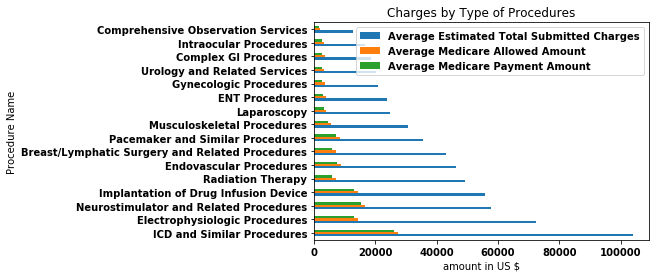

In [107]:
# plot charges by category of procedurs 
OutPatmedcharge_Proc=Merged_df2[['Provider State','ProcedureName','Average Estimated Total Submitted Charges',
       'Average Medicare Allowed Amount', 'Average Medicare Payment Amount']]
OutPatmedcharge_byProcedure=OutPatmedcharge_Proc.groupby('ProcedureName').median().sort_values('Average Estimated Total Submitted Charges', ascending=False)
OutPatmedcharge_byProcedure.head(10)

OutPatmedcharge_byProcedure.plot(kind='barh')
plt.title('Charges by Type of Procedures')
plt.ylabel('Procedure Name')
plt.xlabel('amount in US $')

### In Most States the charge is distributed per complexity of the procedures
### comperhensive observation lies at the bottom and ICD lies at the top

In [108]:
#def f(x):
    # plot charges by category of procedurs 
#    OutPatmedcharge_Proc=Merged_df2[['State','ProcedureName','Average Estimated Total Submitted Charges',
#           'Average Medicare Allowed Amount', 'Average Medicare Payment Amount']]
    # filter state
#    OutPatmedcharge_Proc=OutPatmedcharge_Proc[OutPatmedcharge_Proc.State==x]
    # sort ascending order by charge amount
#    OutPatmedcharge_byProcedure=OutPatmedcharge_Proc.groupby('ProcedureName').median()\
#                              .sort_values('Average Estimated Total Submitted Charges', ascending=False)
   

#    plot_proc=OutPatmedcharge_byProcedure.plot(kind='bar')
#    plt.title('Charges by Type of Procedures')
#    plt.xlabel('Procedure Type')
#    plt.ylabel('amount in US $')
#
#    return plot_proc


In [109]:
#interact(f,x=state_list);

In [110]:
OutPatmedicarecharge['APC Description'].unique()

array(['Level 3 Musculoskeletal Procedures',
       'Level 4 Musculoskeletal Procedures',
       'Level 5 Musculoskeletal Procedures', 'Level 5 ENT Procedures',
       'Level 1 Endovascular Procedures',
       'Level 2 Endovascular Procedures',
       'Level 3 Endovascular Procedures',
       'Level 2 Pacemaker and Similar Procedures',
       'Level 3 Pacemaker and Similar Procedures',
       'Level 1 ICD and Similar Procedures',
       'Level 2 ICD and Similar Procedures', 'Complex GI Procedures',
       'Level 1 Laparoscopy', 'Level 2 Laparoscopy',
       'Level 5 Urology and Related Services',
       'Level 7 Urology and Related Services',
       'Level 5 Gynecologic Procedures',
       'Level 2 Neurostimulator and Related Procedures',
       'Level 2 Intraocular Procedures', 'Level 7 Radiation Therapy',
       'Comprehensive Observation Services',
       'Level 3 Neurostimulator and Related Procedures',
       'Level 3 Electrophysiologic Procedures',
       'Level 6 Urology and Rel

## import county health ranking data 

In [111]:
# import county health ranking data 

countyhealthrank_df=pd.read_excel('data/2016 County Health Rankings Data - v3.xls',sheet_name='Additional Measure Data', index_col=0,skiprows=1)

In [112]:
countyhealthrank_df.columns

Index(['State', 'County', '# Deaths', 'Age-Adjusted Mortality', '95% CI - Low',
       '95% CI - High', '# Deaths.1', 'Child Mortality Rate', '95% CI - Low.1',
       '95% CI - High.1', '# Deaths.2', 'Infant Mortality Rate',
       '95% CI - Low.2', '95% CI - High.2', '% Frequent Physical Distress',
       '95% CI - Low.3', '95% CI - High.3', '% Frequent Mental Distress',
       '95% CI - Low.4', '95% CI - High.4', '% Diabetic', '95% CI - Low.5',
       '95% CI - High.5', '# HIV Cases', 'HIV Prevalence Rate',
       '# Food Insecure', '% Food Insecure', '# Limited Access',
       '% Limited Access to Healthy Foods', '# Drug Overdose Deaths',
       'Drug Overdose Mortality Rate', 'Range Drug Overdose Mortality Rate',
       '# Motor Vehicle Deaths', 'MV Mortality Rate', '95% CI - Low.6',
       '95% CI - High.6', '% Insufficient Sleep', '95% CI - Low.7',
       '95% CI - High.7', '# Uninsured', '% Uninsured adults',
       '95% CI - Low.8', '95% CI - High.8', '# Uninsured.1',
       '%

### my variables= ['State','County','Age-Adjusted Mortality','% 65 and over','Child Mortality Rate','% African American', '% Non-Hispanic White','Household Income','Other PCP Rate','% Uninsured','# Motor Vehicle Deaths','# Drug Overdose Deaths','Drug Overdose Mortality Rate','MV Mortality Rate','% Limited Access','% Diabetic','% Frequent Mental Distress']


In [113]:
# keep only needed columns
healthranking_df=countyhealthrank_df[['State','County','Age-Adjusted Mortality','% 65 and over',
                                      'Child Mortality Rate','% African American', '% Non-Hispanic White',
                                      'Household Income','Other PCP Rate','% Uninsured adults','% Uninsured children',
                                      '# Motor Vehicle Deaths','# Drug Overdose Deaths','Drug Overdose Mortality Rate',
                                      'MV Mortality Rate','% Limited Access to Healthy Foods','% Diabetic',
                                      '% Frequent Mental Distress','% Rural']].reset_index()

In [114]:
healthranking_df.columns

Index(['FIPS', 'State', 'County', 'Age-Adjusted Mortality', '% 65 and over',
       'Child Mortality Rate', '% African American', '% Non-Hispanic White',
       'Household Income', 'Other PCP Rate', '% Uninsured adults',
       '% Uninsured children', '# Motor Vehicle Deaths',
       '# Drug Overdose Deaths', 'Drug Overdose Mortality Rate',
       'MV Mortality Rate', '% Limited Access to Healthy Foods', '% Diabetic',
       '% Frequent Mental Distress', '% Rural'],
      dtype='object')

In [115]:
healthranking_df.head()

,FIPS,State,County,Age-Adjusted Mortality,% 65 and over,Child Mortality Rate,% African American,% Non-Hispanic White,Household Income,Other PCP Rate,% Uninsured adults,% Uninsured children,# Motor Vehicle Deaths,# Drug Overdose Deaths,Drug Overdose Mortality Rate,MV Mortality Rate,% Limited Access to Healthy Foods,% Diabetic,% Frequent Mental Distress,% Rural
0,1001.0,Alabama,Autauga,456.4,13.829768,50.488344,18.494449,75.597076,54366.0,18.0522,17.481181,3.859072,75.0,13.0,7.824020,19.715311,9.793530,10.9,12.8,42.002162
1,1003.0,Alabama,Baldwin,356.0,18.682131,51.342489,9.395785,83.000435,49626.0,33.9811,22.068321,5.713276,204.0,94.0,16.028893,15.900866,5.460261,10.9,12.8,42.279099
2,1005.0,Alabama,Barbour,430.8,16.487522,59.795840,47.193811,46.583851,34971.0,18.5963,22.512599,5.134228,35.0,NaN,NaN,18.222049,11.420316,15.3,14.9,67.789635
3,1007.0,Alabama,Bibb,541.7,14.787168,110.630594,21.909713,74.522350,39546.0,26.6596,19.011225,4.245379,38.0,10.0,14.789618,23.918325,2.144661,12.5,14.3,68.352607
4,1009.0,Alabama,Blount,430.3,17.001334,51.898779,1.637243,87.756198,45567.0,8.66266,22.293381,6.036892,99.0,42.0,24.219079,24.667795,1.062468,11.7,13.8,89.951502


In [116]:
# capitalize County to match with hospital charge data, str(x) will convert the State column to string.
# without doing that in this particular data I got this error "AttributeError: 'float' object has no attribute 'upper"
healthranking_df['County']=healthranking_df.County.apply(lambda x: str(x).upper())

In [117]:
# group by State and County 
#hospitalCharge=Merged_df2[['State','County','Comprehensive APC Services','Average Estimated Total Submitted Charges','star_1','star_2','star_3','star_4','star_5']]\
#                   .groupby(['State','County']).mean().reset_index()
    
hospitalCharge=Merged_df2[['State','County','Average Estimated Total Submitted Charges']]\
               .groupby(['State','County']).mean().reset_index()

In [118]:
# convert the star to integer
#hospitalCharge[['star_1','star_2','star_3','star_4','star_5']]=hospitalCharge[['star_1','star_2','star_3','star_4','star_5']].astype(int)

In [119]:
hospitalCharge.head()

,State,County,Average Estimated Total Submitted Charges
0,Alabama,AUTAUGA,10835.542026
1,Alabama,BALDWIN,39462.389143
2,Alabama,BARBOUR,5412.817131
3,Alabama,BIBB,3440.469737
4,Alabama,BULLOCK,11311.506000


In [120]:
# strip  county column
hospitalCharge['County']=hospitalCharge.County.str.strip()

### Combine Outpatient charge data with county health ranking data

In [121]:
# merge data frames
combined_df=pd.merge(hospitalCharge,healthranking_df,how='left',on=['State','County'])
combined_df.head()

,State,County,Average Estimated Total Submitted Charges,FIPS,Age-Adjusted Mortality,% 65 and over,Child Mortality Rate,% African American,% Non-Hispanic White,Household Income,...,% Uninsured adults,% Uninsured children,# Motor Vehicle Deaths,# Drug Overdose Deaths,Drug Overdose Mortality Rate,MV Mortality Rate,% Limited Access to Healthy Foods,% Diabetic,% Frequent Mental Distress,% Rural
0,Alabama,AUTAUGA,10835.542026,1001.0,456.4,13.829768,50.488344,18.494449,75.597076,54366.0,...,17.481181,3.859072,75.0,13.0,7.824020,19.715311,9.793530,10.9,12.8,42.002162
1,Alabama,BALDWIN,39462.389143,1003.0,356.0,18.682131,51.342489,9.395785,83.000435,49626.0,...,22.068321,5.713276,204.0,94.0,16.028893,15.900866,5.460261,10.9,12.8,42.279099
2,Alabama,BARBOUR,5412.817131,1005.0,430.8,16.487522,59.795840,47.193811,46.583851,34971.0,...,22.512599,5.134228,35.0,NaN,NaN,18.222049,11.420316,15.3,14.9,67.789635
3,Alabama,BIBB,3440.469737,1007.0,541.7,14.787168,110.630594,21.909713,74.522350,39546.0,...,19.011225,4.245379,38.0,10.0,14.789618,23.918325,2.144661,12.5,14.3,68.352607
4,Alabama,BULLOCK,11311.506000,1011.0,469.4,14.864363,152.207002,69.119287,22.120030,26580.0,...,24.238411,4.944110,36.0,NaN,NaN,47.669492,20.151730,17.3,15.5,51.374382


In [122]:
combined_df.shape

(1401, 21)

In [123]:
# plot relationship between rural  % of communities and hospital charges

Text(0.5,0,'percentage of Rural communities')

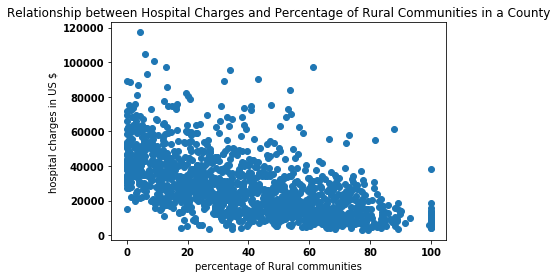

In [124]:
plt.scatter(combined_df['% Rural'],combined_df['Average Estimated Total Submitted Charges'])
plt.title('Relationship between Hospital Charges and Percentage of Rural Communities in a County')
plt.ylabel('hospital charges in US $')
plt.xlabel('percentage of Rural communities')

Text(0.5,0,'percentage of Over 65 Population')

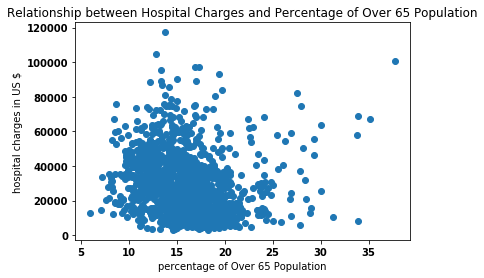

In [125]:
plt.scatter(combined_df['% 65 and over'],combined_df['Average Estimated Total Submitted Charges'])
plt.title('Relationship between Hospital Charges and Percentage of Over 65 Population')
plt.ylabel('hospital charges in US $')
plt.xlabel('percentage of Over 65 Population')

Text(0.5,0,'Other PCP Rate')

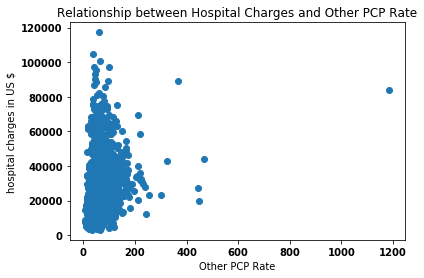

In [126]:
plt.scatter(combined_df['Other PCP Rate'],combined_df['Average Estimated Total Submitted Charges'])
plt.title('Relationship between Hospital Charges and Other PCP Rate')
plt.ylabel('hospital charges in US $')
plt.xlabel('Other PCP Rate')

Text(0.5,0,'% Uninsured adults')

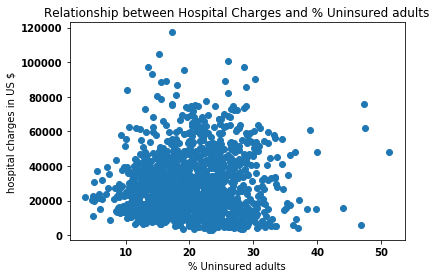

In [127]:
plt.scatter(combined_df['% Uninsured adults'],combined_df['Average Estimated Total Submitted Charges'])
plt.title('Relationship between Hospital Charges and % Uninsured adults')
plt.ylabel('hospital charges in US $')
plt.xlabel('% Uninsured adults')

Text(0.5,0,'% Uninsured children')

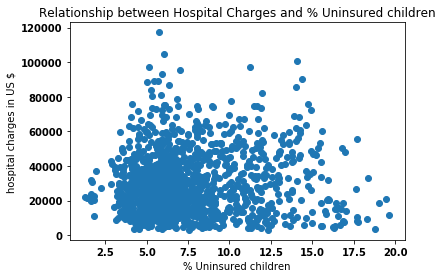

In [128]:
plt.scatter(combined_df['% Uninsured children'],combined_df['Average Estimated Total Submitted Charges'])
plt.title('Relationship between Hospital Charges and % Uninsured children')
plt.ylabel('hospital charges in US $')
plt.xlabel('% Uninsured children')

Text(0.5,0,'% African American')

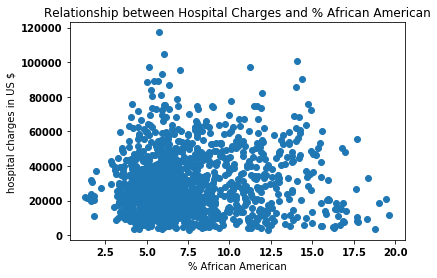

In [129]:
plt.scatter(combined_df['% Uninsured children'],combined_df['Average Estimated Total Submitted Charges'])
plt.title('Relationship between Hospital Charges and % African American')
plt.ylabel('hospital charges in US $')
plt.xlabel('% African American')

Text(0.5,0,'% of Population With Limited Access to Healthy Foods')

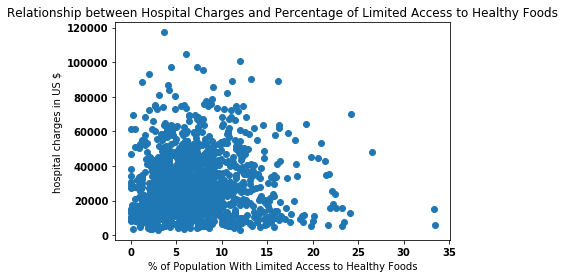

In [130]:
plt.scatter(combined_df['% Limited Access to Healthy Foods'],combined_df['Average Estimated Total Submitted Charges'])
plt.title('Relationship between Hospital Charges and Percentage of Limited Access to Healthy Foods')
plt.ylabel('hospital charges in US $')
plt.xlabel('% of Population With Limited Access to Healthy Foods')

In [131]:
from sklearn.cluster import KMeans
X=combined_df[['Average Estimated Total Submitted Charges']]
Kmean = KMeans(n_clusters=4)
Kmean.fit(X)
# display cluster centers
Kmean.cluster_centers_

array([[12920.63126097],
       [44951.79104662],
       [28453.16546858],
       [69285.88893438]])

In [132]:
#salary=pd.read_excel("data/state_M2016_dl.xlsx")
#salary.head()

In [133]:
#salary=salary[salary.OCC_TITLE=='Physicians and Surgeons, All Other']
#salary=salary[['STATE','OCC_TITLE','A_MEAN']]
#salary.columns=['State','OCC_TITLE','AveYearlySalary']
#salary.sort_values('AveYearlySalary',ascending=False).plot(kind='bar',x='State',y='AveYearlySalary')

In [134]:
# merge salary data
#combined_data=pd.merge(combined_df,salary, how='left',on='State')
#combined_data.columns

In [135]:
# import linear regression model
import scipy.stats as stats
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import preprocessing  # helps for reshaping X and y
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
from scipy import stats


C:\Users\fevty\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning:

The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.



### Use Lassso Regression it will filters out less important variables

In [136]:
combined_df=combined_df.dropna(axis=0)

In [137]:
# shape of the data after dropping na horizontally 
combined_df.shape

(1121, 21)

In [138]:
# convert Other PCP rate to numeric
combined_df['Other PCP Rate']=pd.to_numeric(combined_df['Other PCP Rate'])
# print data info
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1121 entries, 0 to 1398
Data columns (total 21 columns):
State                                        1121 non-null object
County                                       1121 non-null object
Average Estimated Total Submitted Charges    1121 non-null float64
FIPS                                         1121 non-null float64
Age-Adjusted Mortality                       1121 non-null float64
% 65 and over                                1121 non-null float64
Child Mortality Rate                         1121 non-null float64
% African American                           1121 non-null float64
% Non-Hispanic White                         1121 non-null float64
Household Income                             1121 non-null float64
Other PCP Rate                               1121 non-null float64
% Uninsured adults                           1121 non-null float64
% Uninsured children                         1121 non-null float64
# Motor Vehicle Deaths  

In [139]:
# drop FIPS
combined_df=combined_df.drop(['FIPS'],axis=1)

In [140]:
combined_df.columns

Index(['State', 'County', 'Average Estimated Total Submitted Charges',
       'Age-Adjusted Mortality', '% 65 and over', 'Child Mortality Rate',
       '% African American', '% Non-Hispanic White', 'Household Income',
       'Other PCP Rate', '% Uninsured adults', '% Uninsured children',
       '# Motor Vehicle Deaths', '# Drug Overdose Deaths',
       'Drug Overdose Mortality Rate', 'MV Mortality Rate',
       '% Limited Access to Healthy Foods', '% Diabetic',
       '% Frequent Mental Distress', '% Rural'],
      dtype='object')

In [141]:
combined_df.shape

(1121, 20)

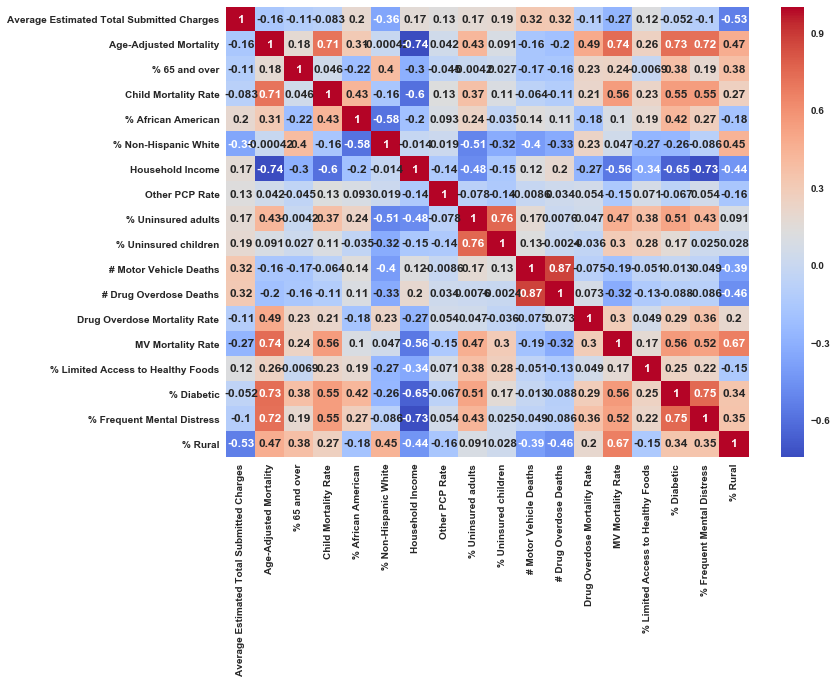

In [142]:
# plot correlation between variables
combined_corr_df=combined_df.iloc[:,2:21]
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(combined_corr_df.corr(),cmap='coolwarm',annot=True);

In [143]:
# drop mortality rates and '% Frequent Mental Distress data because they have strong correlation with other variables
combined_df=combined_df.drop(['Age-Adjusted Mortality','Child Mortality Rate','MV Mortality Rate','% Frequent Mental Distress'],axis=1)


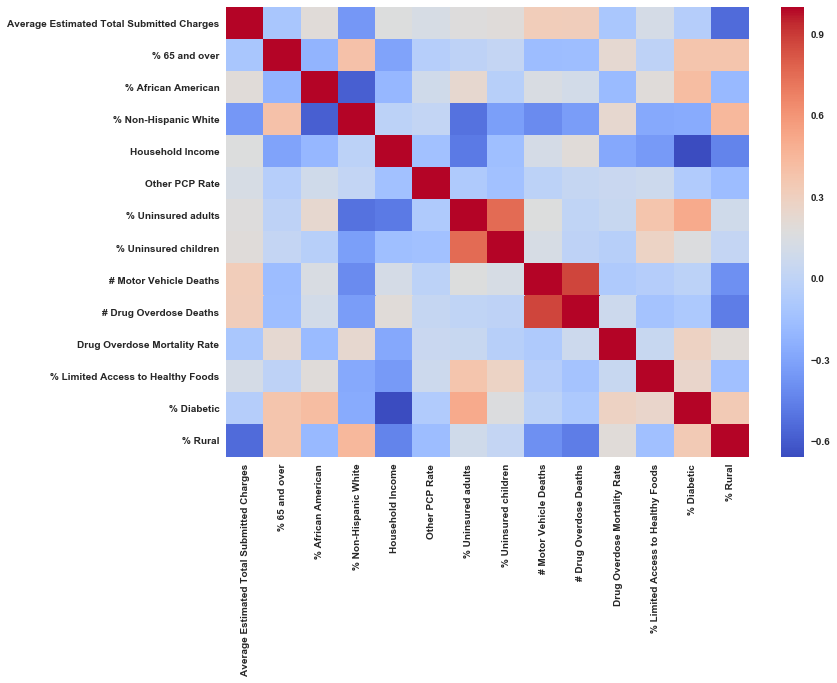

In [144]:
# plot correlation between variables after dropping strongly correlated variables
combined_corr_df=combined_df.iloc[:,2:21]
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.heatmap(combined_corr_df.corr(),cmap='coolwarm',annot=False);

In [145]:
# define features and target to predict using all features 

# define y
# define X and y variables
y=combined_df.iloc[:,2]
X=combined_df.iloc[:,3:21]
#X=  combined_df[['% 65 and over','% Non-Hispanic White', 'Household Income',
#       '% Uninsured adults', '% Uninsured children', '# Motor Vehicle Deaths','# Drug Overdose Deaths', '% Limited Access to Healthy Foods', '% Diabetic','Other PCP Rate','% Rural']]

In [146]:
combined_df.iloc[:,3:21].columns

Index(['% 65 and over', '% African American', '% Non-Hispanic White',
       'Household Income', 'Other PCP Rate', '% Uninsured adults',
       '% Uninsured children', '# Motor Vehicle Deaths',
       '# Drug Overdose Deaths', 'Drug Overdose Mortality Rate',
       '% Limited Access to Healthy Foods', '% Diabetic', '% Rural'],
      dtype='object')

In [147]:
X.shape

(1121, 13)

In [148]:
# split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33,random_state=42)

### Lasso model penalizes large coeffient variables, and removes irrelevant variables by making the coefficient zero.
### However, in this case the model didn't droop any variable

In [149]:
# import lasso
from sklearn.linear_model import Lasso

In [150]:

lasso_reg = linear_model.Lasso(alpha=1, normalize=True) 
# fit and predict with lasso model
lasso_reg.fit(X_train,y_train)
train_score=lasso_reg.score(X_train,y_train)
test_score=lasso_reg.score(X_test,y_test)
coeff_used = np.sum(lasso_reg.coef_!=0)

# print scores
print("training score:", train_score) 
print("test score: ", test_score)
print("number of features used: ", coeff_used)

print(lasso_reg.coef_)



training score: 0.40618226334896457
test score:  0.30930225138299805
number of features used:  13
[ 7.00834221e+02  1.72430718e+02  8.43908907e+00  1.18569844e-01
  3.82277267e+01  4.77630094e+02  4.97976166e+02  7.14002282e+00
 -4.65754325e+00  6.54198744e+00 -1.20136622e+02  6.77987612e+01
 -3.86790738e+02]


#### % of % of elrderly population, % of uninsured(both adults and children), % of African American have positive relation with hospital charge
#### Household Income,  % of diabetic population,Non-Hispanic White, Motor Vehicle Deaths, Other to Primary Care Physicains ratio  have very small positive relation with hospital charges.
#### % of Rural Population in the county, % of population with Limited Access to Healthy Foods, Number of Services Provided by the Hospitals have negative relation with hospital charge
#### Drug Overdose deaths and MV mortality rates have zero or weak relation with hospital charge

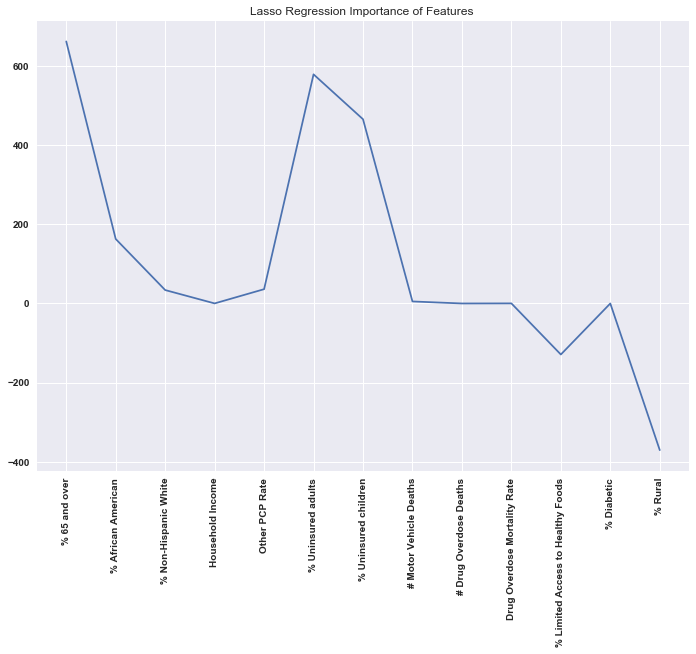

In [151]:
# plot lasso coeficients
lasso_coef=lasso_reg.fit(X,y).coef_
plt.plot(range(len(X.columns)),lasso_coef)
plt.xticks(range(len(X.columns)),X.columns,rotation=90)
plt.title('Lasso Regression Importance of Features ')
plt.show()


In [152]:
# define the model
lmodel_st=LinearRegression()
lmodel_st.fit(X_train,y_train)
# predict the model
y_pred=lmodel_st.predict(X_test)
print('R score: %.2f' % r2_score(y_test, y_pred))
print ('Mean Square Error:%.2f' % mean_squared_error(y_test,y_pred))
lmodel_st.coef_

R score: 0.31
Mean Square Error:224297512.02


array([ 7.06652938e+02,  1.80194768e+02,  1.79368862e+01,  1.28396950e-01,
        3.93894471e+01,  4.91219802e+02,  5.02129162e+02,  8.28807125e+00,
       -6.67394882e+00,  1.76572134e+01, -1.36926424e+02,  1.11493569e+02,
       -3.92238102e+02])

### - Limited access to healthy food is highly associated particularly with  those living in low-income neighborhoods,communities of color, and rural areas, hospital located in those localities may charge lower prices.
### - This could be a possible explanation why it has negative effect on hospital charges
### - Low R-squared score  and very large constant term imply that hospital charge may not be determined by competition in the market rather it is influenced by the hospitals charge master which is mainly administrative decision. 

In [153]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

C:\Users\fevty\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning:

numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.



In [154]:
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                                        OLS Regression Results                                       
Dep. Variable:     Average Estimated Total Submitted Charges   R-squared:                       0.373
Model:                                                   OLS   Adj. R-squared:                  0.366
Method:                                        Least Squares   F-statistic:                     50.76
Date:                                       Sat, 11 May 2019   Prob (F-statistic):          7.96e-103
Time:                                               13:21:33   Log-Likelihood:                -12262.
No. Observations:                                       1121   AIC:                         2.455e+04
Df Residuals:                                           1107   BIC:                         2.462e+04
Df Model:                                                 13                                         
Covariance Type:                                   nonrobust                      

In [155]:
# define X and y variables
y=combined_df.iloc[:,2]
#X=combined_df.iloc[:,3:21]
# 
#X=combined_df.iloc[:,-1]abs
X=combined_df[['% Uninsured adults','% Uninsured children','% 65 and over','% Rural', '% African American']]


# split the data into train and test, 33% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [156]:
# define the model
lmodel=LinearRegression()
lmodel.fit(X_train,y_train)
# predict the model
y_pred=lmodel.predict(X_test)

# reshape it becuase it is only one feature
#X=X.values.reshape(-1,1)
print('R score: %.2f' % r2_score(y_test, y_pred))
print ('Mean Square Error:%.2f' % mean_squared_error(y_test,y_pred))


R score: 0.29
Mean Square Error:229632436.90


In [157]:
# Print coefficients

lmodel.coef_

array([ 349.96095318,  590.65874067,  619.33328921, -430.1958492 ,
        164.43023809])

###  more  % of Uninsured population(both adults and children) , and elderly population in Counties is positively  related with higher hospital charges 
#### i.e. Hospitals are shifting costs from uninsured to insured patients.
### 1 % increase in % of uninsured adults increases  hospital charge by $427 and a % rise in uninsured children increases hospital charges by $622  ,1% increase in proportion of Rural communities in the counties decreases hospital charges by $429.85

In [158]:
# use OLS linear regression model

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                                        OLS Regression Results                                       
Dep. Variable:     Average Estimated Total Submitted Charges   R-squared:                       0.355
Model:                                                   OLS   Adj. R-squared:                  0.352
Method:                                        Least Squares   F-statistic:                     122.8
Date:                                       Sat, 11 May 2019   Prob (F-statistic):          1.34e-103
Time:                                               13:21:34   Log-Likelihood:                -12279.
No. Observations:                                       1121   AIC:                         2.457e+04
Df Residuals:                                           1115   BIC:                         2.460e+04
Df Model:                                                  5                                         
Covariance Type:                                   nonrobust                      

[8.80905041e-04 2.90483262e-04 3.15351740e-03 0.00000000e+00
 1.13333132e-03 4.77356538e-03 6.82602792e-02 6.11830176e-01
 1.14241537e-03 0.00000000e+00 3.43141812e-04 0.00000000e+00
 3.08192185e-01]


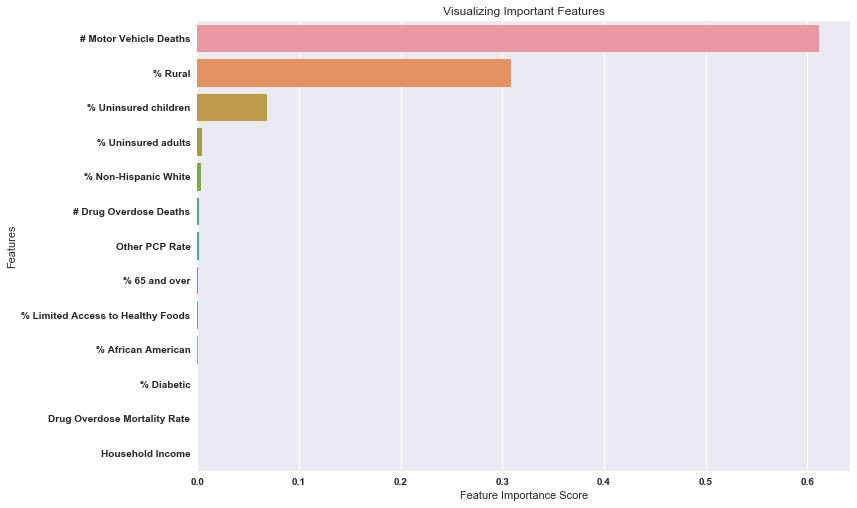

In [159]:

# define features and target to predict using all features 

# define y
# define X and y variables
y=combined_df.iloc[:,2]
X=combined_df.iloc[:,3:21]
#X=  combined_df[['% 65 and over','% Non-Hispanic White', 'Household Income',
#       '% Uninsured adults', '% Uninsured children', '# Motor Vehicle Deaths','# Drug Overdose Deaths', '% Limited Access to Healthy Foods', '% Diabetic','Other PCP Rate','% Rural']]

# Random Forest Model
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn import metrics

# define random forest function
regr = RandomForestRegressor(max_depth=2, random_state=0,n_estimators=100)
# fit the model
regr.fit(X, y)
# print feature importance
print(regr.feature_importances_)
regr.predict(X)
regr.score(X, y, sample_weight=None)
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

# calculate feature importance 
feature_imp = pd.Series(regr.feature_importances_,index=X.columns).sort_values(ascending=False)
feature_imp
# Creating a bar plot that shows feature importance
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

### Import 2014 and 2015 data

In [160]:
#outpatientcharge2014=pd.read_csv('data/Outpatient_Prospective_Payment_System__OPPS__Provider_Summary_for_32_Selected_Ambulatory_Payment_Classification__APC__Groups_-_CY2014.csv')
#outpatientcharge2014.head()

In [161]:
#stateMedianCharge2015.to_csv('data/state_median_charge2015.csv',index=False)

In [162]:
#outpatientcharge2013=pd.read_csv('data/Medicare_Provider_Charge_Outpatient_APC30_CY2013_v2.csv')
#outpatientcharge2013.head()

In [163]:
#oupatientcharge2012=pd.read_csv('data/Medicare_Provider_Charge_Outpatient_APC30_CY2012.csv')

#oupatientcharge2012.head()

In [164]:
#print(oupatientcharge2012['Average  Estimated Submitted Charges'].mean())
#print(Merged_df2['Average Estimated Total Submitted Charges'].mean())

In [165]:
#county_location=gpd.read_file('data/County_Location.geojson')
#county_location.head()

In [166]:
#county_location=county_location[['COUNTY_NAME','geometry']]\
#.rename(columns={'COUNTY_NAME':'County'})
#county_location.head()

In [167]:
#combined_df['County']=combined_df['County'].apply(lambda x: x.upper())

### Import inpatient data and combine with information data and try regression models

# Things to do on Today

- Use Quality Indicators data from hospital information  data
- Check national comparison for readmission 
- Do Every Analysis for one Procedure: Example Level 3 Endovascular Procedure.